#    Notebook Setup

In [1]:
import os
import random
import numpy as np
from pathlib import Path
from typing import List
from tqdm import tqdm
import struct
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from keras.utils import to_categorical
import keras
warnings.filterwarnings('ignore')
random.seed(14)

# 1: Data preprocessing

In [2]:
# GET DATA
# 1. vectorize it
# 2. normalize it
# 3. final results: four variables: X train, X test, Y train, y test with explanations 

In [3]:
# Step 1. We define the path for the datasets
filename_train_images = '/data/fashion-data/train-images-idx3-ubyte'
filename_train_labels = '/data/fashion-data/train-labels-idx1-ubyte'
filename_test_images = '/data/fashion-data/t10k-images-idx3-ubyte'
filename_test_labels = '/data/fashion-data/t10k-labels-idx1-ubyte'

path=os.path.join(Path().absolute(), 'data/fashion-data')

In [4]:
# Step 2. We define two functions for loading the training and testing sets:

def load_mnist_train(path, kind='train'):    
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

def load_mnist_test(path, kind='t10k'):
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    return images, labels  

# Get the training data + labels & testing data + labels
# Note: labels: 0-9 for both training and testing sets
train_images,train_labels=load_mnist_train(path) 
test_images,test_labels=load_mnist_test(path)    

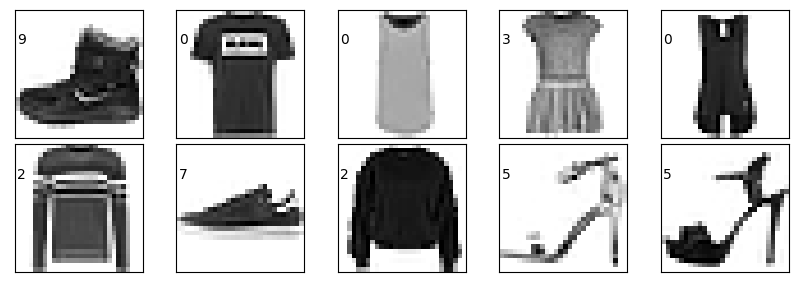

In [5]:
# Step 3. print the first 30 training figures(with labels) for a simple show:
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for i in range(10):
    images = np.reshape(train_images[i], [28,28])
    ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[])
    ax.imshow(images,cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0,7,str(train_labels[i]))
plt.show()

In [6]:
# Step 4. normalize training data (size: 60k)
train_images_norm=train_images 

for i in range(len(train_images)):
    # normalize the training data
    train_images_norm[i]  = (train_images_norm[i]- np.mean(train_images_norm[i], axis = 0))/np.std(train_images_norm[i], axis = 0)
    

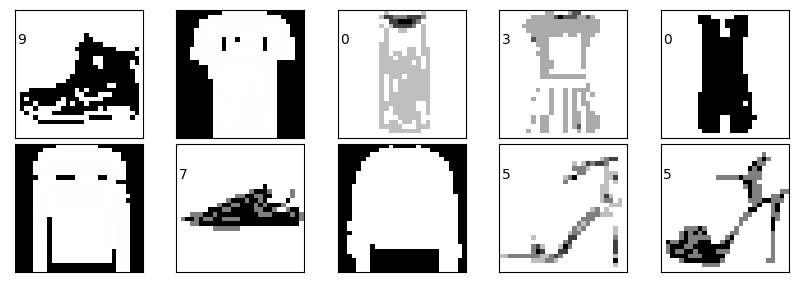

In [7]:
# after normalization, print the first 30 training figures(with labels) for a simple show:
# the characteristics of a figure are kept nicely.
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for i in range(10):
    images = np.reshape(train_images_norm[i], [28,28])
    ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[])
    ax.imshow(images,cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0,7,str(train_labels[i]))
plt.show()

In [8]:
# Step 5. normalize the testing dataset (size: 10k)
test_images_norm=test_images 

for i in range(len(test_images)):
    # normalize the testing data
    test_images_norm[i]  = (test_images_norm[i]- np.mean(test_images_norm[i], axis = 0))/np.std(test_images_norm[i], axis = 0)
     

In [9]:
# Finally our variables: 
# - training set: train_images_norm (training data), train_labels (labels of training data)
# - testing set: test_images_norm (testing data), test_labels (labels of testing data)

#    2: Implement MLP

In [10]:
def evaluate_acc(y_hat, y):
    return np.sum(y == y_hat)/y.shape[0]

In [11]:
# The main NN layer
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None # Only linear layers will have an updatable paramater
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [200]:
# Children layers: 1- the linear layer, our main componenet of the MLP,
# Have bias, updatable params ...
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size, l2_reg=False):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.l2_reg = l2_reg
        self.w = np.random.randn(output_size, input_size) * .01
        self.b = np.random.randn(output_size) * .01
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        if self.l2_reg:
            dw += self.l2_reg * np.sum(np.dot(gradient,np.transpose(gradient)))/self.cur_input.shape[0]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [13]:
# Children layers: 2- the Relu, activation layer, does not maintain any params
# Non linear function of the input 
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [14]:
# Children layers: 3- the Softmax, activation layer, does not maintain any params
# will be used just as output layer, gradient of combined cross-entropy and softmax 

class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [15]:
# Children layers: 4- the Softpluslayer, another activation layer, does not maintain any params

class Softpluslayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = 1 / ( 1+ np.exp(-x))
        return np.log(1 + np.exp(x))
    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [16]:
# Children layers: - the LeakyRelu, activation layer, does not maintain any params
# Non linear function of the input 
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.01)
        return np.maximum(0.01, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [17]:
# Children layers: 6- the tanh, activation layer, does not maintain any params
# Non linear function of the input 
class tanhLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        tanh=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        self.gradient = 1-tanh**2
        return tanh

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [124]:
# The MLP class, will be used to create our Neural Network, it takes a list (sequence)
# of the layers defined above. First we go through the layers and perform forward pass
# for each layer. Then we go from the last layer to the first layer to perform the backward
# pass.
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args
        self.gradient = 1 

        

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def step(self):
        for layer in self.layers: # [::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)
        return 0

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0) # + self.l2_reg*l2_penalty(w)

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
        return 0

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, lr=0.01, max_iters=1e4, 
                            epsilon=1e-8, batch_size = 1, early_stopping=False, look_back=1, verbose=True):
        self.losses_train = []
        self.acc_train = []
        self.losses_valid = []
        self.acc_valid = []
        epoch = 1   

        self.lr = lr
        y_train_orig = y_train.copy()
        y_train = np.eye(10)[np.array(y_train)]
        if y_valid is not None: 
            y_valid_orig = y_valid.copy()
            y_valid = np.eye(10)[np.array(y_valid)]

        while epoch < max_iters+1:   #np.linalg.norm(self.gradient) > epsilon 
            # we are now going to be dealing with a SINGLE EPOCH

            # shuffle the data
            shuffled_indices = np.asanyarray(range(X_train.shape[0])) 
            random.shuffle(shuffled_indices)    # new shuffled indices
            X_shuffled = X_train[shuffled_indices]
            y_shuffled = y_train[shuffled_indices]
            num_mini_batches = X_shuffled.shape[0]//batch_size
            # store the loss of each minibatch
            minibatch_losses_train = []
            minibatch_losses_valid = []
            
            n = 0
            for _ in tqdm(range(num_mini_batches)):
                
                # Set endpoints for minibatches
                minibatch_start_index = n * batch_size
                minibatch_end_index = minibatch_start_index + batch_size
                n+=1
                # define current minibatch data
                minibatch_X = X_shuffled[minibatch_start_index:minibatch_end_index]
                minibatch_y = y_shuffled[minibatch_start_index:minibatch_end_index]
                predictions = self.forward(minibatch_X)
                loss = - ( minibatch_y * np.log(predictions)).sum(axis=-1).mean()
                minibatch_losses_train.append(loss)
                self.backward(minibatch_y)
                self.step() # optimizer update wights N_data/Batch size for each dataset
                if X_valid is not None and y_valid is not None: # if we are using validation data
                    predictions = self.forward(X_valid)
                    # calculate the loss on our validation data
                    loss = - ( y_valid * np.log(predictions)).sum(axis=-1).mean()
                    minibatch_losses_valid.append(loss)
                    # no backward or step update in validation
                # Now, we are done with all minibatches in the current epoch --------------------------

            # add the sum of this minibatch's error to the total error at this epoch
            batch_train_loss = np.mean(minibatch_losses_train)
            self.losses_train.append(batch_train_loss)  # store this in minibatch loss
            train_pred = self.predict(X_train)
            acc= evaluate_acc(np.array(train_pred), y_train_orig)
            self.acc_train.append(acc)
            if X_valid is not None and y_valid is not None:
                batch_valid_loss = np.mean(minibatch_losses_valid)
                self.losses_valid.append(batch_valid_loss)  # store this in minibatch loss
                valid_pred = self.predict(X_valid)
                acc_valid= evaluate_acc(np.array(valid_pred), y_valid_orig)
                self.acc_valid.append(acc_valid)
                # if ( epoch % 100 )==0 or epoch==1:                  # print loss each 100 iteration
                print(f"epoch {epoch}: Train loss: {batch_train_loss:.3f}; Test Loss: {batch_valid_loss:.3f}, , Train Accuracy: {acc:.3f}, , Test Accuracy: {acc_valid:.3f}")
                # if we are looking minibatch by minibatch, we can only stop when we are on the second minibatch (i.e. n >=1)
                if early_stopping and epoch > look_back:  # perform early stopping over epochs not iterations
                    # If we want to stop early, we need to see if there has been an increase in validation error, from current

                    # compare current validation to the mean of i last validation losses (again, for the minibatch updates)
                    loss_is_greater = (batch_valid_loss > np.mean(self.losses_valid[epoch-1-look_back:epoch-1]))  

                    if loss_is_greater:
                        print(f'Early stopping at epoch {epoch} due to increase in validation loss.')
                        losses_train = losses_train[:epoch-1]
                        break    # stopping condition

            else:
                # if ( epoch % 100 )==0 or epoch==1:                  # print loss each 100 epoch
                print(f"epoch {epoch}: Loss: {batch_train_loss:.3f}, Accuracy: {acc:.3f}")

            epoch += 1

        # Gradient descent is now done (all epochs completed) -----------
                
        if verbose:
            print(f'terminated after {epoch-1} epochs')
            # print(f'the weight found: {w}')


        return self
            
    def predict(self, x):
        yh = self.forward(x)
        yh = np.argmax(yh, axis=-1)
        return yh


# 3: Experiments

##### Impact of number of layers; Model depth

In [38]:
n_features = 784 # Input
n_hidden = 128 # n of X (forget what to call it) by hidden layer
n_classes = 10
# A 0 layer MLP
mlp0 = MLP(
    LinearLayer(n_features, n_classes), #map input layer to output
    SoftmaxOutputLayer()
)

In [39]:
mlp0.fit( train_images_norm, train_labels, max_iters=50, batch_size=500, lr=0.0001)

100%|██████████| 120/120 [00:01<00:00, 69.06it/s]


epoch 1: Loss: 13.826, Accuracy: 0.253


100%|██████████| 120/120 [00:01<00:00, 83.16it/s]


epoch 2: Loss: 8.989, Accuracy: 0.335


100%|██████████| 120/120 [00:01<00:00, 81.80it/s]


epoch 3: Loss: 7.643, Accuracy: 0.377


100%|██████████| 120/120 [00:01<00:00, 83.26it/s]


epoch 4: Loss: 7.305, Accuracy: 0.426


100%|██████████| 120/120 [00:01<00:00, 75.71it/s]


epoch 5: Loss: 7.412, Accuracy: 0.431


100%|██████████| 120/120 [00:01<00:00, 85.96it/s]


epoch 6: Loss: 6.757, Accuracy: 0.441


100%|██████████| 120/120 [00:01<00:00, 83.18it/s]


epoch 7: Loss: 6.488, Accuracy: 0.454


100%|██████████| 120/120 [00:02<00:00, 58.10it/s]


epoch 8: Loss: 6.608, Accuracy: 0.461


100%|██████████| 120/120 [00:01<00:00, 71.76it/s]


epoch 9: Loss: 6.374, Accuracy: 0.440


100%|██████████| 120/120 [00:01<00:00, 78.37it/s]


epoch 10: Loss: 6.870, Accuracy: 0.479


100%|██████████| 120/120 [00:01<00:00, 82.51it/s]


epoch 11: Loss: 6.050, Accuracy: 0.476


100%|██████████| 120/120 [00:01<00:00, 86.71it/s]


epoch 12: Loss: 5.970, Accuracy: 0.492


100%|██████████| 120/120 [00:01<00:00, 78.27it/s]


epoch 13: Loss: 6.393, Accuracy: 0.483


100%|██████████| 120/120 [00:01<00:00, 78.64it/s]


epoch 14: Loss: 6.178, Accuracy: 0.451


100%|██████████| 120/120 [00:01<00:00, 80.17it/s]


epoch 15: Loss: 6.486, Accuracy: 0.483


100%|██████████| 120/120 [00:01<00:00, 79.45it/s]


epoch 16: Loss: 5.722, Accuracy: 0.479


100%|██████████| 120/120 [00:01<00:00, 69.47it/s]


epoch 17: Loss: 6.187, Accuracy: 0.510


100%|██████████| 120/120 [00:01<00:00, 78.23it/s]


epoch 18: Loss: 6.124, Accuracy: 0.481


100%|██████████| 120/120 [00:01<00:00, 79.56it/s]


epoch 19: Loss: 5.965, Accuracy: 0.530


100%|██████████| 120/120 [00:01<00:00, 79.09it/s]


epoch 20: Loss: 5.918, Accuracy: 0.504


100%|██████████| 120/120 [00:01<00:00, 73.55it/s]


epoch 21: Loss: 5.856, Accuracy: 0.517


100%|██████████| 120/120 [00:01<00:00, 70.60it/s]


epoch 22: Loss: 5.610, Accuracy: 0.525


100%|██████████| 120/120 [00:01<00:00, 81.49it/s]


epoch 23: Loss: 5.615, Accuracy: 0.517


100%|██████████| 120/120 [00:01<00:00, 75.63it/s]


epoch 24: Loss: 6.111, Accuracy: 0.527


100%|██████████| 120/120 [00:01<00:00, 76.26it/s]


epoch 25: Loss: 5.882, Accuracy: 0.548


100%|██████████| 120/120 [00:01<00:00, 80.25it/s]


epoch 26: Loss: 5.575, Accuracy: 0.492


100%|██████████| 120/120 [00:01<00:00, 82.02it/s]


epoch 27: Loss: 5.817, Accuracy: 0.506


100%|██████████| 120/120 [00:01<00:00, 77.55it/s]


epoch 28: Loss: 5.742, Accuracy: 0.547


100%|██████████| 120/120 [00:01<00:00, 80.23it/s]


epoch 29: Loss: 5.868, Accuracy: 0.505


100%|██████████| 120/120 [00:01<00:00, 79.45it/s]


epoch 30: Loss: 5.935, Accuracy: 0.550


100%|██████████| 120/120 [00:01<00:00, 79.63it/s]


epoch 31: Loss: 5.757, Accuracy: 0.530


100%|██████████| 120/120 [00:01<00:00, 80.30it/s]


epoch 32: Loss: 5.580, Accuracy: 0.539


100%|██████████| 120/120 [00:01<00:00, 77.51it/s]


epoch 33: Loss: 5.778, Accuracy: 0.484


100%|██████████| 120/120 [00:01<00:00, 79.01it/s]


epoch 34: Loss: 5.699, Accuracy: 0.539


100%|██████████| 120/120 [00:01<00:00, 78.15it/s]


epoch 35: Loss: 5.709, Accuracy: 0.543


100%|██████████| 120/120 [00:01<00:00, 77.58it/s]


epoch 36: Loss: 5.546, Accuracy: 0.547


100%|██████████| 120/120 [00:01<00:00, 79.39it/s]


epoch 37: Loss: 5.598, Accuracy: 0.559


100%|██████████| 120/120 [00:01<00:00, 81.58it/s]


epoch 38: Loss: 5.647, Accuracy: 0.531


100%|██████████| 120/120 [00:01<00:00, 76.15it/s]


epoch 39: Loss: 5.287, Accuracy: 0.524


100%|██████████| 120/120 [00:01<00:00, 72.42it/s]


epoch 40: Loss: 5.550, Accuracy: 0.570


100%|██████████| 120/120 [00:01<00:00, 73.02it/s]


epoch 41: Loss: 5.540, Accuracy: 0.541


100%|██████████| 120/120 [00:01<00:00, 71.30it/s]


epoch 42: Loss: 5.490, Accuracy: 0.536


100%|██████████| 120/120 [00:01<00:00, 67.89it/s]


epoch 43: Loss: 5.722, Accuracy: 0.545


100%|██████████| 120/120 [00:01<00:00, 76.56it/s]


epoch 44: Loss: 5.659, Accuracy: 0.537


100%|██████████| 120/120 [00:01<00:00, 71.44it/s]


epoch 45: Loss: 5.902, Accuracy: 0.570


100%|██████████| 120/120 [00:01<00:00, 64.13it/s]


epoch 46: Loss: 5.090, Accuracy: 0.553


100%|██████████| 120/120 [00:01<00:00, 73.07it/s]


epoch 47: Loss: 5.929, Accuracy: 0.536


100%|██████████| 120/120 [00:01<00:00, 75.73it/s]


epoch 48: Loss: 5.695, Accuracy: 0.568


100%|██████████| 120/120 [00:01<00:00, 73.23it/s]


epoch 49: Loss: 5.865, Accuracy: 0.572


100%|██████████| 120/120 [00:01<00:00, 65.19it/s]


epoch 50: Loss: 5.160, Accuracy: 0.528
terminated after 51 epochs


In [54]:
# A 1 layer MLP
mlp1 = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden, n_classes), #Hidden layer 1
    SoftmaxOutputLayer()
)

In [55]:
#TODO fit models and get accuray + test using normalized data to see the difference
mlp1.fit( train_images_norm, train_labels, max_iters=50, batch_size=500, lr=0.001)

100%|██████████| 120/120 [00:18<00:00,  6.37it/s]


epoch 1: Loss: 1.900, Accuracy: 0.377


100%|██████████| 120/120 [00:19<00:00,  6.23it/s]


epoch 2: Loss: 1.754, Accuracy: 0.495


100%|██████████| 120/120 [00:19<00:00,  6.13it/s]


epoch 3: Loss: 1.724, Accuracy: 0.500


100%|██████████| 120/120 [00:18<00:00,  6.56it/s]


epoch 4: Loss: 1.709, Accuracy: 0.496


100%|██████████| 120/120 [00:18<00:00,  6.55it/s]


epoch 5: Loss: 1.692, Accuracy: 0.491


100%|██████████| 120/120 [00:18<00:00,  6.33it/s]


epoch 6: Loss: 1.679, Accuracy: 0.485


100%|██████████| 120/120 [00:18<00:00,  6.55it/s]


epoch 7: Loss: 1.662, Accuracy: 0.483


100%|██████████| 120/120 [00:18<00:00,  6.48it/s]


epoch 8: Loss: 1.649, Accuracy: 0.480


100%|██████████| 120/120 [00:18<00:00,  6.51it/s]


epoch 9: Loss: 1.631, Accuracy: 0.478


100%|██████████| 120/120 [00:18<00:00,  6.58it/s]


epoch 10: Loss: 1.611, Accuracy: 0.477


100%|██████████| 120/120 [00:18<00:00,  6.58it/s]


epoch 11: Loss: 1.588, Accuracy: 0.475


100%|██████████| 120/120 [00:19<00:00,  6.17it/s]


epoch 12: Loss: 1.564, Accuracy: 0.475


100%|██████████| 120/120 [00:19<00:00,  6.24it/s]


epoch 13: Loss: 1.539, Accuracy: 0.475


100%|██████████| 120/120 [00:21<00:00,  5.48it/s]


epoch 14: Loss: 1.509, Accuracy: 0.476


100%|██████████| 120/120 [00:20<00:00,  5.92it/s]


epoch 15: Loss: 1.478, Accuracy: 0.473


100%|██████████| 120/120 [00:20<00:00,  5.83it/s]


epoch 16: Loss: 1.446, Accuracy: 0.467


100%|██████████| 120/120 [00:19<00:00,  6.07it/s]


epoch 17: Loss: 1.415, Accuracy: 0.474


100%|██████████| 120/120 [00:19<00:00,  6.25it/s]


epoch 18: Loss: 1.384, Accuracy: 0.478


100%|██████████| 120/120 [00:21<00:00,  5.49it/s]


epoch 19: Loss: 1.354, Accuracy: 0.480


100%|██████████| 120/120 [00:18<00:00,  6.46it/s]


epoch 20: Loss: 1.329, Accuracy: 0.481


100%|██████████| 120/120 [00:19<00:00,  6.19it/s]


epoch 21: Loss: 1.304, Accuracy: 0.485


100%|██████████| 120/120 [00:19<00:00,  6.22it/s]


epoch 22: Loss: 1.278, Accuracy: 0.491


100%|██████████| 120/120 [00:19<00:00,  6.30it/s]


epoch 23: Loss: 1.258, Accuracy: 0.501


100%|██████████| 120/120 [00:18<00:00,  6.43it/s]


epoch 24: Loss: 1.239, Accuracy: 0.507


100%|██████████| 120/120 [00:18<00:00,  6.40it/s]


epoch 25: Loss: 1.220, Accuracy: 0.521


100%|██████████| 120/120 [00:18<00:00,  6.51it/s]


epoch 26: Loss: 1.203, Accuracy: 0.534


100%|██████████| 120/120 [00:18<00:00,  6.51it/s]


epoch 27: Loss: 1.188, Accuracy: 0.544


100%|██████████| 120/120 [00:18<00:00,  6.61it/s]


epoch 28: Loss: 1.172, Accuracy: 0.554


100%|██████████| 120/120 [00:18<00:00,  6.55it/s]


epoch 29: Loss: 1.159, Accuracy: 0.563


100%|██████████| 120/120 [00:18<00:00,  6.38it/s]


epoch 30: Loss: 1.147, Accuracy: 0.570


100%|██████████| 120/120 [00:21<00:00,  5.68it/s]


epoch 31: Loss: 1.134, Accuracy: 0.578


100%|██████████| 120/120 [00:18<00:00,  6.45it/s]


epoch 32: Loss: 1.122, Accuracy: 0.582


100%|██████████| 120/120 [00:20<00:00,  5.73it/s]


epoch 33: Loss: 1.109, Accuracy: 0.592


100%|██████████| 120/120 [00:21<00:00,  5.56it/s]


epoch 34: Loss: 1.098, Accuracy: 0.598


100%|██████████| 120/120 [00:18<00:00,  6.51it/s]


epoch 35: Loss: 1.087, Accuracy: 0.601


100%|██████████| 120/120 [00:17<00:00,  6.81it/s]


epoch 36: Loss: 1.076, Accuracy: 0.609


100%|██████████| 120/120 [00:17<00:00,  6.73it/s]


epoch 37: Loss: 1.066, Accuracy: 0.617


100%|██████████| 120/120 [00:18<00:00,  6.58it/s]


epoch 38: Loss: 1.056, Accuracy: 0.624


100%|██████████| 120/120 [00:18<00:00,  6.53it/s]


epoch 39: Loss: 1.047, Accuracy: 0.627


100%|██████████| 120/120 [00:18<00:00,  6.40it/s]


epoch 40: Loss: 1.036, Accuracy: 0.631


100%|██████████| 120/120 [00:18<00:00,  6.54it/s]


epoch 41: Loss: 1.029, Accuracy: 0.638


100%|██████████| 120/120 [00:18<00:00,  6.54it/s]


epoch 42: Loss: 1.017, Accuracy: 0.642


100%|██████████| 120/120 [00:17<00:00,  6.72it/s]


epoch 43: Loss: 1.011, Accuracy: 0.645


100%|██████████| 120/120 [00:18<00:00,  6.61it/s]


epoch 44: Loss: 1.000, Accuracy: 0.648


100%|██████████| 120/120 [00:18<00:00,  6.58it/s]


epoch 45: Loss: 0.992, Accuracy: 0.648


100%|██████████| 120/120 [00:20<00:00,  5.84it/s]


epoch 46: Loss: 0.985, Accuracy: 0.654


100%|██████████| 120/120 [00:20<00:00,  5.97it/s]


epoch 47: Loss: 0.976, Accuracy: 0.656


100%|██████████| 120/120 [00:19<00:00,  6.24it/s]


epoch 48: Loss: 0.967, Accuracy: 0.655


100%|██████████| 120/120 [00:18<00:00,  6.43it/s]


epoch 49: Loss: 0.962, Accuracy: 0.656


100%|██████████| 120/120 [00:19<00:00,  6.28it/s]


epoch 50: Loss: 0.953, Accuracy: 0.662
terminated after 51 epochs


In [79]:
# A 2 layer MLP
mlp2 = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden, n_hidden), #Hidden layer 1
    ReLULayer(), # 
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [80]:
#TODO fit models and get accuray + test using normalized data to see the difference
mlp2.fit( train_images_norm, train_labels,max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:22<00:00,  2.65it/s]


epoch 1: Loss: 1.900, Accuracy: 0.331


100%|██████████| 60/60 [00:26<00:00,  2.25it/s]


epoch 2: Loss: 1.790, Accuracy: 0.337


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]


epoch 3: Loss: 1.756, Accuracy: 0.342


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


epoch 4: Loss: 1.729, Accuracy: 0.350


100%|██████████| 60/60 [00:21<00:00,  2.79it/s]


epoch 5: Loss: 1.717, Accuracy: 0.359


100%|██████████| 60/60 [00:21<00:00,  2.79it/s]


epoch 6: Loss: 1.706, Accuracy: 0.381


100%|██████████| 60/60 [00:21<00:00,  2.77it/s]


epoch 7: Loss: 1.696, Accuracy: 0.445


100%|██████████| 60/60 [00:21<00:00,  2.76it/s]


epoch 8: Loss: 1.685, Accuracy: 0.456


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]


epoch 9: Loss: 1.675, Accuracy: 0.445


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]


epoch 10: Loss: 1.667, Accuracy: 0.460


100%|██████████| 60/60 [00:21<00:00,  2.79it/s]


epoch 11: Loss: 1.659, Accuracy: 0.465


100%|██████████| 60/60 [00:22<00:00,  2.73it/s]


epoch 12: Loss: 1.654, Accuracy: 0.468


100%|██████████| 60/60 [00:21<00:00,  2.78it/s]


epoch 13: Loss: 1.644, Accuracy: 0.489


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


epoch 14: Loss: 1.639, Accuracy: 0.523


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]


epoch 15: Loss: 1.630, Accuracy: 0.507


100%|██████████| 60/60 [00:21<00:00,  2.77it/s]


epoch 16: Loss: 1.622, Accuracy: 0.482


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


epoch 17: Loss: 1.611, Accuracy: 0.480


100%|██████████| 60/60 [00:21<00:00,  2.80it/s]


epoch 18: Loss: 1.591, Accuracy: 0.476


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


epoch 19: Loss: 1.569, Accuracy: 0.476


100%|██████████| 60/60 [00:21<00:00,  2.80it/s]


epoch 20: Loss: 1.531, Accuracy: 0.473


100%|██████████| 60/60 [00:21<00:00,  2.79it/s]


epoch 21: Loss: 1.466, Accuracy: 0.474


100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


epoch 22: Loss: 1.387, Accuracy: 0.472


100%|██████████| 60/60 [00:21<00:00,  2.80it/s]


epoch 23: Loss: 1.309, Accuracy: 0.477


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


epoch 24: Loss: 1.251, Accuracy: 0.475


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


epoch 25: Loss: 1.216, Accuracy: 0.480


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


epoch 26: Loss: 1.190, Accuracy: 0.484


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


epoch 27: Loss: 1.169, Accuracy: 0.490


100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


epoch 28: Loss: 1.151, Accuracy: 0.496


100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


epoch 29: Loss: 1.133, Accuracy: 0.508


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


epoch 30: Loss: 1.114, Accuracy: 0.506


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


epoch 31: Loss: 1.099, Accuracy: 0.536


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


epoch 32: Loss: 1.083, Accuracy: 0.553


100%|██████████| 60/60 [00:20<00:00,  2.90it/s]


epoch 33: Loss: 1.061, Accuracy: 0.575


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


epoch 34: Loss: 1.041, Accuracy: 0.594


100%|██████████| 60/60 [00:20<00:00,  2.94it/s]


epoch 35: Loss: 1.018, Accuracy: 0.619


100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


epoch 36: Loss: 1.000, Accuracy: 0.626


100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


epoch 37: Loss: 0.974, Accuracy: 0.633


100%|██████████| 60/60 [00:20<00:00,  2.90it/s]


epoch 38: Loss: 0.954, Accuracy: 0.642


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


epoch 39: Loss: 0.936, Accuracy: 0.649


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]


epoch 40: Loss: 0.913, Accuracy: 0.656


100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


epoch 41: Loss: 0.895, Accuracy: 0.659


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


epoch 42: Loss: 0.883, Accuracy: 0.657


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


epoch 43: Loss: nan, Accuracy: 0.664


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


epoch 44: Loss: nan, Accuracy: 0.674


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


epoch 45: Loss: nan, Accuracy: 0.683


100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


epoch 46: Loss: nan, Accuracy: 0.691


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


epoch 47: Loss: nan, Accuracy: 0.692


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


epoch 48: Loss: nan, Accuracy: 0.700


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


epoch 49: Loss: nan, Accuracy: 0.708


100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


epoch 50: Loss: nan, Accuracy: 0.714
terminated after 51 epochs


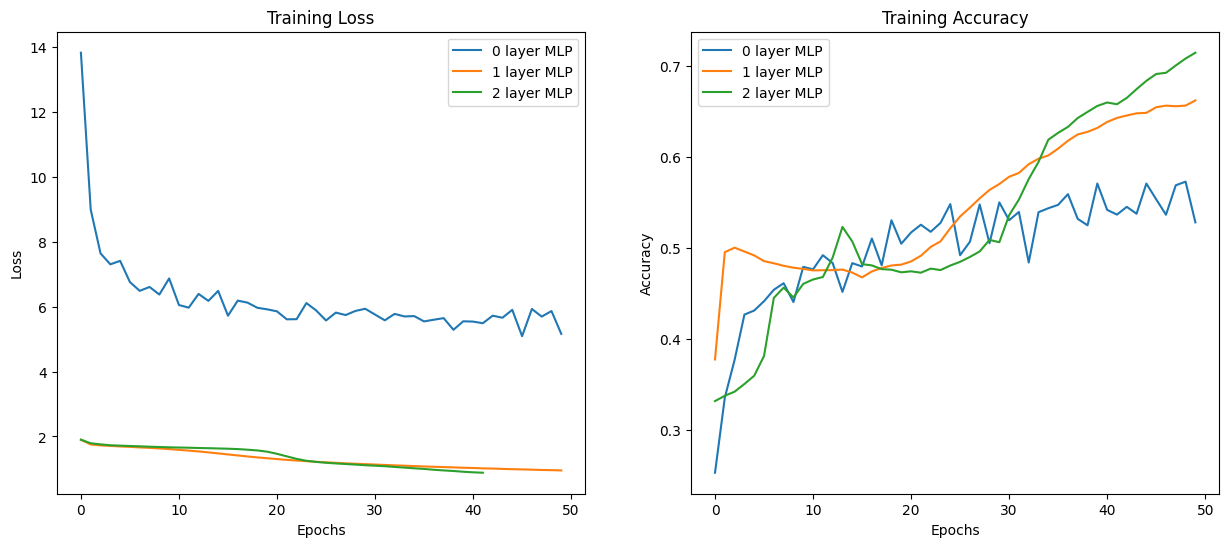

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(mlp0.losses_train, label='0 layer MLP')
axes[0].plot(mlp1.losses_train, label='1 layer MLP')
axes[0].plot(mlp2.losses_train, label='2 layer MLP')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

axes[1].plot(mlp0.acc_train, label='0 layer MLP')
axes[1].plot(mlp1.acc_train, label='1 layer MLP')
axes[1].plot(mlp2.acc_train, label='2 layer MLP')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].legend()
plt.show()
fig.savefig("impact_depths.png")

In [92]:
#Test accuracy for the 3 models
test_res=mlp0.predict(test_images_norm)
print("Test accuracy for 0 layer MLP: ", evaluate_acc(test_res, test_labels))
test_res=mlp1.predict(test_images_norm)
print("Test accuracy for 1 layer MLP: ", evaluate_acc(test_res, test_labels))
test_res=mlp2.predict(test_images_norm)
print("Test accuracy for 2 layers MLP: ", evaluate_acc(test_res, test_labels))

Test accuracy for 0 layer MLP:  0.5209
Test accuracy for 1 layer MLP:  0.6397
Test accuracy for 2 layers MLP:  0.6954


##### Impact of number of hidden units per layer; Model width

In [100]:
n_hidden_input = 64
# A 2 layer MLP
mlp_64 = MLP(
    LinearLayer(n_features, n_hidden_input), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden_input, n_hidden), #Hidden layer 1
    ReLULayer(), # 
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [101]:
mlp_64.fit( train_images_norm, train_labels,max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:12<00:00,  4.88it/s]


epoch 1: Loss: 1.925, Accuracy: 0.306


100%|██████████| 60/60 [00:10<00:00,  5.53it/s]


epoch 2: Loss: 1.801, Accuracy: 0.319


100%|██████████| 60/60 [00:10<00:00,  5.60it/s]


epoch 3: Loss: 1.771, Accuracy: 0.341


100%|██████████| 60/60 [00:10<00:00,  5.59it/s]


epoch 4: Loss: 1.743, Accuracy: 0.358


100%|██████████| 60/60 [00:10<00:00,  5.54it/s]


epoch 5: Loss: 1.724, Accuracy: 0.359


100%|██████████| 60/60 [00:11<00:00,  5.29it/s]


epoch 6: Loss: 1.714, Accuracy: 0.362


100%|██████████| 60/60 [00:11<00:00,  5.40it/s]


epoch 7: Loss: 1.699, Accuracy: 0.355


100%|██████████| 60/60 [00:10<00:00,  5.53it/s]


epoch 8: Loss: 1.694, Accuracy: 0.365


100%|██████████| 60/60 [00:10<00:00,  5.50it/s]


epoch 9: Loss: 1.677, Accuracy: 0.358


100%|██████████| 60/60 [00:10<00:00,  5.54it/s]


epoch 10: Loss: 1.671, Accuracy: 0.382


100%|██████████| 60/60 [00:11<00:00,  5.44it/s]


epoch 11: Loss: 1.666, Accuracy: 0.453


100%|██████████| 60/60 [00:17<00:00,  3.41it/s]


epoch 12: Loss: 1.657, Accuracy: 0.496


100%|██████████| 60/60 [00:12<00:00,  4.93it/s]


epoch 13: Loss: 1.649, Accuracy: 0.499


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


epoch 14: Loss: 1.644, Accuracy: 0.483


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


epoch 15: Loss: 1.637, Accuracy: 0.486


100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


epoch 16: Loss: 1.626, Accuracy: 0.482


100%|██████████| 60/60 [00:12<00:00,  4.91it/s]


epoch 17: Loss: 1.616, Accuracy: 0.476


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


epoch 18: Loss: 1.603, Accuracy: 0.460


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


epoch 19: Loss: 1.580, Accuracy: 0.464


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


epoch 20: Loss: 1.547, Accuracy: 0.472


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


epoch 21: Loss: 1.491, Accuracy: 0.473


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


epoch 22: Loss: 1.417, Accuracy: 0.473


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


epoch 23: Loss: 1.334, Accuracy: 0.475


100%|██████████| 60/60 [00:11<00:00,  5.07it/s]


epoch 24: Loss: 1.272, Accuracy: 0.475


100%|██████████| 60/60 [00:11<00:00,  5.26it/s]


epoch 25: Loss: 1.233, Accuracy: 0.478


100%|██████████| 60/60 [00:11<00:00,  5.31it/s]


epoch 26: Loss: 1.205, Accuracy: 0.479


100%|██████████| 60/60 [00:11<00:00,  5.45it/s]


epoch 27: Loss: 1.182, Accuracy: 0.484


100%|██████████| 60/60 [00:10<00:00,  5.55it/s]


epoch 28: Loss: 1.161, Accuracy: 0.490


100%|██████████| 60/60 [00:10<00:00,  5.70it/s]


epoch 29: Loss: 1.146, Accuracy: 0.488


100%|██████████| 60/60 [00:11<00:00,  5.38it/s]


epoch 30: Loss: 1.130, Accuracy: 0.506


100%|██████████| 60/60 [00:10<00:00,  5.55it/s]


epoch 31: Loss: 1.114, Accuracy: 0.518


100%|██████████| 60/60 [00:11<00:00,  5.45it/s]


epoch 32: Loss: 1.099, Accuracy: 0.534


100%|██████████| 60/60 [00:10<00:00,  5.51it/s]


epoch 33: Loss: 1.077, Accuracy: 0.545


100%|██████████| 60/60 [00:10<00:00,  5.58it/s]


epoch 34: Loss: 1.062, Accuracy: 0.580


100%|██████████| 60/60 [00:11<00:00,  5.27it/s]


epoch 35: Loss: 1.041, Accuracy: 0.602


100%|██████████| 60/60 [00:10<00:00,  5.68it/s]


epoch 36: Loss: 1.020, Accuracy: 0.614


100%|██████████| 60/60 [00:10<00:00,  5.58it/s]


epoch 37: Loss: 1.001, Accuracy: 0.626


100%|██████████| 60/60 [00:11<00:00,  5.45it/s]


epoch 38: Loss: 0.977, Accuracy: 0.616


100%|██████████| 60/60 [00:11<00:00,  5.39it/s]


epoch 39: Loss: 0.959, Accuracy: 0.636


100%|██████████| 60/60 [00:12<00:00,  4.71it/s]


epoch 40: Loss: 0.940, Accuracy: 0.648


100%|██████████| 60/60 [00:11<00:00,  5.42it/s]


epoch 41: Loss: 0.920, Accuracy: 0.643


100%|██████████| 60/60 [00:11<00:00,  5.26it/s]


epoch 42: Loss: 0.905, Accuracy: 0.655


100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


epoch 43: Loss: 0.892, Accuracy: 0.661


100%|██████████| 60/60 [00:11<00:00,  5.33it/s]


epoch 44: Loss: 0.873, Accuracy: 0.664


100%|██████████| 60/60 [00:11<00:00,  5.35it/s]


epoch 45: Loss: 0.863, Accuracy: 0.652


100%|██████████| 60/60 [00:10<00:00,  5.54it/s]


epoch 46: Loss: nan, Accuracy: 0.676


100%|██████████| 60/60 [00:11<00:00,  5.41it/s]


epoch 47: Loss: nan, Accuracy: 0.683


100%|██████████| 60/60 [00:11<00:00,  5.34it/s]


epoch 48: Loss: nan, Accuracy: 0.692


100%|██████████| 60/60 [00:11<00:00,  5.41it/s]


epoch 49: Loss: nan, Accuracy: 0.697


100%|██████████| 60/60 [00:11<00:00,  5.38it/s]


epoch 50: Loss: nan, Accuracy: 0.698
terminated after 51 epochs


In [104]:
n_hidden_2 = 256
# A 2 layer MLP
mlp_128_256 = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden, n_hidden_2), #Hidden layer 1
    ReLULayer(), # 
    LinearLayer(n_hidden_2, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [105]:
mlp_128_256.fit( train_images_norm, train_labels,max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:42<00:00,  1.43it/s]


epoch 1: Loss: 1.895, Accuracy: 0.342


100%|██████████| 60/60 [00:25<00:00,  2.34it/s]


epoch 2: Loss: 1.784, Accuracy: 0.350


100%|██████████| 60/60 [00:29<00:00,  2.00it/s]


epoch 3: Loss: 1.752, Accuracy: 0.353


100%|██████████| 60/60 [01:00<00:00,  1.01s/it]


epoch 4: Loss: 1.728, Accuracy: 0.359


100%|██████████| 60/60 [00:28<00:00,  2.13it/s]


epoch 5: Loss: 1.710, Accuracy: 0.357


100%|██████████| 60/60 [00:29<00:00,  2.06it/s]


epoch 6: Loss: 1.699, Accuracy: 0.401


100%|██████████| 60/60 [00:25<00:00,  2.35it/s]


epoch 7: Loss: 1.687, Accuracy: 0.455


100%|██████████| 60/60 [00:54<00:00,  1.11it/s]


epoch 8: Loss: 1.674, Accuracy: 0.461


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


epoch 9: Loss: 1.664, Accuracy: 0.462


100%|██████████| 60/60 [00:25<00:00,  2.32it/s]


epoch 10: Loss: 1.659, Accuracy: 0.493


100%|██████████| 60/60 [00:24<00:00,  2.43it/s]


epoch 11: Loss: 1.649, Accuracy: 0.517


100%|██████████| 60/60 [00:24<00:00,  2.45it/s]


epoch 12: Loss: 1.641, Accuracy: 0.518


100%|██████████| 60/60 [00:25<00:00,  2.39it/s]


epoch 13: Loss: 1.635, Accuracy: 0.495


100%|██████████| 60/60 [00:24<00:00,  2.42it/s]


epoch 14: Loss: 1.620, Accuracy: 0.493


100%|██████████| 60/60 [07:53<00:00,  7.89s/it]   


epoch 15: Loss: 1.609, Accuracy: 0.484


100%|██████████| 60/60 [00:27<00:00,  2.18it/s]


epoch 16: Loss: 1.585, Accuracy: 0.480


100%|██████████| 60/60 [00:28<00:00,  2.08it/s]


epoch 17: Loss: 1.553, Accuracy: 0.472


100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


epoch 18: Loss: 1.505, Accuracy: 0.476


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 19: Loss: 1.434, Accuracy: 0.475


100%|██████████| 60/60 [00:28<00:00,  2.07it/s]


epoch 20: Loss: 1.354, Accuracy: 0.465


100%|██████████| 60/60 [00:25<00:00,  2.34it/s]


epoch 21: Loss: 1.285, Accuracy: 0.477


100%|██████████| 60/60 [00:27<00:00,  2.15it/s]


epoch 22: Loss: 1.231, Accuracy: 0.485


100%|██████████| 60/60 [00:33<00:00,  1.79it/s]


epoch 23: Loss: 1.199, Accuracy: 0.496


100%|██████████| 60/60 [00:29<00:00,  2.04it/s]


epoch 24: Loss: 1.173, Accuracy: 0.503


100%|██████████| 60/60 [00:34<00:00,  1.75it/s]


epoch 25: Loss: 1.146, Accuracy: 0.513


100%|██████████| 60/60 [00:32<00:00,  1.86it/s]


epoch 26: Loss: 1.125, Accuracy: 0.528


100%|██████████| 60/60 [00:30<00:00,  1.99it/s]


epoch 27: Loss: 1.101, Accuracy: 0.537


100%|██████████| 60/60 [00:32<00:00,  1.83it/s]


epoch 28: Loss: 1.082, Accuracy: 0.563


100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


epoch 29: Loss: 1.059, Accuracy: 0.584


100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


epoch 30: Loss: 1.036, Accuracy: 0.609


100%|██████████| 60/60 [00:28<00:00,  2.09it/s]


epoch 31: Loss: 1.012, Accuracy: 0.625


100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


epoch 32: Loss: 0.989, Accuracy: 0.632


100%|██████████| 60/60 [00:29<00:00,  2.02it/s]


epoch 33: Loss: 0.967, Accuracy: 0.638


100%|██████████| 60/60 [00:56<00:00,  1.06it/s]


epoch 34: Loss: 0.942, Accuracy: 0.637


100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


epoch 35: Loss: 0.921, Accuracy: 0.656


100%|██████████| 60/60 [00:27<00:00,  2.19it/s]


epoch 36: Loss: 0.902, Accuracy: 0.657


100%|██████████| 60/60 [00:25<00:00,  2.34it/s]


epoch 37: Loss: 0.881, Accuracy: 0.665


100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


epoch 38: Loss: 0.867, Accuracy: 0.670


100%|██████████| 60/60 [00:26<00:00,  2.27it/s]


epoch 39: Loss: nan, Accuracy: 0.671


100%|██████████| 60/60 [00:26<00:00,  2.31it/s]


epoch 40: Loss: nan, Accuracy: 0.684


100%|██████████| 60/60 [00:27<00:00,  2.14it/s]


epoch 41: Loss: nan, Accuracy: 0.688


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 42: Loss: nan, Accuracy: 0.690


100%|██████████| 60/60 [00:27<00:00,  2.21it/s]


epoch 43: Loss: nan, Accuracy: 0.595


100%|██████████| 60/60 [01:49<00:00,  1.82s/it]


epoch 44: Loss: nan, Accuracy: 0.684


100%|██████████| 60/60 [00:25<00:00,  2.37it/s]


epoch 45: Loss: nan, Accuracy: 0.692


100%|██████████| 60/60 [00:25<00:00,  2.37it/s]


epoch 46: Loss: nan, Accuracy: 0.708


100%|██████████| 60/60 [00:28<00:00,  2.12it/s]


epoch 47: Loss: nan, Accuracy: 0.711


100%|██████████| 60/60 [00:28<00:00,  2.11it/s]


epoch 48: Loss: nan, Accuracy: 0.714


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


epoch 49: Loss: nan, Accuracy: 0.727


100%|██████████| 60/60 [00:24<00:00,  2.44it/s]


epoch 50: Loss: nan, Accuracy: 0.727
terminated after 51 epochs


In [107]:
mlp_256 = MLP(
    LinearLayer(n_features, n_hidden_2), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden_2, n_hidden_2), #Hidden layer 1
    ReLULayer(), # 
    LinearLayer(n_hidden_2, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [108]:
mlp_256.fit( train_images_norm, train_labels,max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


epoch 1: Loss: 1.881, Accuracy: 0.329


100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


epoch 2: Loss: 1.773, Accuracy: 0.353


100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


epoch 3: Loss: 1.742, Accuracy: 0.347


100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


epoch 4: Loss: 1.720, Accuracy: 0.392


100%|██████████| 60/60 [00:43<00:00,  1.39it/s]


epoch 5: Loss: 1.700, Accuracy: 0.437


100%|██████████| 60/60 [00:43<00:00,  1.39it/s]


epoch 6: Loss: 1.688, Accuracy: 0.444


100%|██████████| 60/60 [00:50<00:00,  1.20it/s]


epoch 7: Loss: 1.678, Accuracy: 0.464


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


epoch 8: Loss: 1.665, Accuracy: 0.506


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 9: Loss: 1.650, Accuracy: 0.516


100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


epoch 10: Loss: 1.642, Accuracy: 0.501


100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


epoch 11: Loss: 1.626, Accuracy: 0.480


100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


epoch 12: Loss: 1.606, Accuracy: 0.473


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 13: Loss: 1.584, Accuracy: 0.457


100%|██████████| 60/60 [00:52<00:00,  1.15it/s]


epoch 14: Loss: 1.539, Accuracy: 0.475


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 15: Loss: 1.477, Accuracy: 0.471


100%|██████████| 60/60 [00:50<00:00,  1.18it/s]


epoch 16: Loss: 1.395, Accuracy: 0.476


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 17: Loss: 1.310, Accuracy: 0.477


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


epoch 18: Loss: 1.245, Accuracy: 0.481


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 19: Loss: 1.205, Accuracy: 0.483


100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


epoch 20: Loss: 1.174, Accuracy: 0.493


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 21: Loss: 1.149, Accuracy: 0.503


100%|██████████| 60/60 [00:53<00:00,  1.12it/s]


epoch 22: Loss: 1.128, Accuracy: 0.520


100%|██████████| 60/60 [00:55<00:00,  1.08it/s]


epoch 23: Loss: 1.106, Accuracy: 0.542


100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


epoch 24: Loss: 1.079, Accuracy: 0.554


100%|██████████| 60/60 [00:55<00:00,  1.09it/s]


epoch 25: Loss: 1.057, Accuracy: 0.585


100%|██████████| 60/60 [00:56<00:00,  1.05it/s]


epoch 26: Loss: 1.030, Accuracy: 0.617


100%|██████████| 60/60 [00:52<00:00,  1.13it/s]


epoch 27: Loss: 1.005, Accuracy: 0.630


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


epoch 28: Loss: 0.979, Accuracy: 0.638


100%|██████████| 60/60 [00:52<00:00,  1.13it/s]


epoch 29: Loss: 0.951, Accuracy: 0.651


100%|██████████| 60/60 [00:52<00:00,  1.14it/s]


epoch 30: Loss: 0.925, Accuracy: 0.655


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


epoch 31: Loss: 0.900, Accuracy: 0.664


100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


epoch 32: Loss: 0.880, Accuracy: 0.671


100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


epoch 33: Loss: 0.857, Accuracy: 0.675


100%|██████████| 60/60 [00:48<00:00,  1.23it/s]


epoch 34: Loss: nan, Accuracy: 0.682


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 35: Loss: nan, Accuracy: 0.690


100%|██████████| 60/60 [00:50<00:00,  1.20it/s]


epoch 36: Loss: nan, Accuracy: 0.701


100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


epoch 37: Loss: nan, Accuracy: 0.701


100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


epoch 38: Loss: nan, Accuracy: 0.714


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


epoch 39: Loss: nan, Accuracy: 0.714


100%|██████████| 60/60 [00:49<00:00,  1.20it/s]


epoch 40: Loss: nan, Accuracy: 0.722


100%|██████████| 60/60 [00:50<00:00,  1.18it/s]


epoch 41: Loss: nan, Accuracy: 0.735


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 42: Loss: nan, Accuracy: 0.740


100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


epoch 43: Loss: nan, Accuracy: 0.736


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 44: Loss: nan, Accuracy: 0.743


100%|██████████| 60/60 [00:49<00:00,  1.20it/s]


epoch 45: Loss: nan, Accuracy: 0.750


100%|██████████| 60/60 [00:50<00:00,  1.20it/s]


epoch 46: Loss: nan, Accuracy: 0.758


100%|██████████| 60/60 [00:53<00:00,  1.13it/s]


epoch 47: Loss: nan, Accuracy: 0.765


100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


epoch 48: Loss: nan, Accuracy: 0.765


100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


epoch 49: Loss: nan, Accuracy: 0.764


100%|██████████| 60/60 [00:53<00:00,  1.13it/s]


epoch 50: Loss: nan, Accuracy: 0.763
terminated after 51 epochs


In [111]:
mlp_256_128 = MLP(
    LinearLayer(n_features, n_hidden_2), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden_2, n_hidden), #Hidden layer 1
    ReLULayer(), # 
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [112]:
mlp_256_128.fit( train_images_norm, train_labels,max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


epoch 1: Loss: 1.900, Accuracy: 0.303


100%|██████████| 60/60 [00:42<00:00,  1.40it/s]


epoch 2: Loss: 1.788, Accuracy: 0.336


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


epoch 3: Loss: 1.747, Accuracy: 0.357


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


epoch 4: Loss: 1.732, Accuracy: 0.358


100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


epoch 5: Loss: 1.712, Accuracy: 0.368


100%|██████████| 60/60 [00:43<00:00,  1.39it/s]


epoch 6: Loss: 1.702, Accuracy: 0.377


100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


epoch 7: Loss: 1.687, Accuracy: 0.453


100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


epoch 8: Loss: 1.677, Accuracy: 0.467


100%|██████████| 60/60 [00:44<00:00,  1.33it/s]


epoch 9: Loss: 1.669, Accuracy: 0.475


100%|██████████| 60/60 [00:41<00:00,  1.46it/s]


epoch 10: Loss: 1.658, Accuracy: 0.481


100%|██████████| 60/60 [00:43<00:00,  1.39it/s]


epoch 11: Loss: 1.652, Accuracy: 0.490


100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


epoch 12: Loss: 1.643, Accuracy: 0.502


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


epoch 13: Loss: 1.635, Accuracy: 0.516


100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


epoch 14: Loss: 1.628, Accuracy: 0.516


100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


epoch 15: Loss: 1.617, Accuracy: 0.515


100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


epoch 16: Loss: 1.603, Accuracy: 0.496


100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


epoch 17: Loss: 1.583, Accuracy: 0.482


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


epoch 18: Loss: 1.559, Accuracy: 0.478


100%|██████████| 60/60 [00:43<00:00,  1.39it/s]


epoch 19: Loss: 1.512, Accuracy: 0.476


100%|██████████| 60/60 [00:46<00:00,  1.28it/s]


epoch 20: Loss: 1.442, Accuracy: 0.467


100%|██████████| 60/60 [00:42<00:00,  1.42it/s]


epoch 21: Loss: 1.358, Accuracy: 0.466


100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


epoch 22: Loss: 1.280, Accuracy: 0.476


100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


epoch 23: Loss: 1.232, Accuracy: 0.481


100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


epoch 24: Loss: 1.195, Accuracy: 0.488


100%|██████████| 60/60 [00:45<00:00,  1.30it/s]


epoch 25: Loss: 1.166, Accuracy: 0.495


100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


epoch 26: Loss: 1.145, Accuracy: 0.508


100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


epoch 27: Loss: 1.120, Accuracy: 0.521


100%|██████████| 60/60 [00:41<00:00,  1.44it/s]


epoch 28: Loss: 1.095, Accuracy: 0.549


100%|██████████| 60/60 [00:54<00:00,  1.10it/s]


epoch 29: Loss: 1.073, Accuracy: 0.583


100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


epoch 30: Loss: 1.045, Accuracy: 0.600


100%|██████████| 60/60 [00:44<00:00,  1.36it/s]


epoch 31: Loss: 1.021, Accuracy: 0.624


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


epoch 32: Loss: 0.992, Accuracy: 0.634


100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


epoch 33: Loss: 0.967, Accuracy: 0.639


100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


epoch 34: Loss: 0.937, Accuracy: 0.653


100%|██████████| 60/60 [00:42<00:00,  1.41it/s]


epoch 35: Loss: 0.917, Accuracy: 0.661


100%|██████████| 60/60 [00:44<00:00,  1.36it/s]


epoch 36: Loss: nan, Accuracy: 0.662


100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


epoch 37: Loss: nan, Accuracy: 0.673


100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


epoch 38: Loss: nan, Accuracy: 0.679


100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


epoch 39: Loss: nan, Accuracy: 0.669


100%|██████████| 60/60 [00:42<00:00,  1.40it/s]


epoch 40: Loss: nan, Accuracy: 0.688


100%|██████████| 60/60 [00:44<00:00,  1.36it/s]


epoch 41: Loss: nan, Accuracy: 0.701


100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


epoch 42: Loss: nan, Accuracy: 0.702


100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


epoch 43: Loss: nan, Accuracy: 0.707


100%|██████████| 60/60 [00:52<00:00,  1.15it/s]


epoch 44: Loss: nan, Accuracy: 0.715


100%|██████████| 60/60 [00:50<00:00,  1.18it/s]


epoch 45: Loss: nan, Accuracy: 0.720


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


epoch 46: Loss: nan, Accuracy: 0.726


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


epoch 47: Loss: nan, Accuracy: 0.729


100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


epoch 48: Loss: nan, Accuracy: 0.729


100%|██████████| 60/60 [00:40<00:00,  1.48it/s]


epoch 49: Loss: nan, Accuracy: 0.735


100%|██████████| 60/60 [00:41<00:00,  1.44it/s]


epoch 50: Loss: nan, Accuracy: 0.743
terminated after 51 epochs


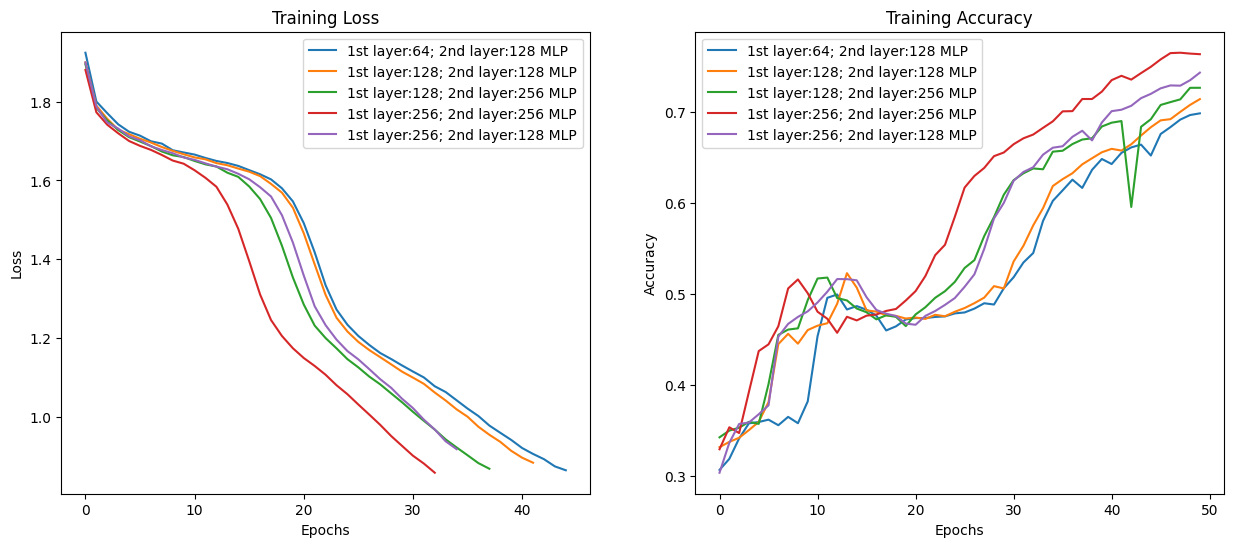

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(mlp_64.losses_train, label='1st layer:64; 2nd layer:128 MLP')
axes[0].plot(mlp2.losses_train, label='1st layer:128; 2nd layer:128 MLP')
axes[0].plot(mlp_128_256.losses_train, label='1st layer:128; 2nd layer:256 MLP')
axes[0].plot(mlp_256.losses_train, label='1st layer:256; 2nd layer:256 MLP')
axes[0].plot(mlp_256_128.losses_train, label='1st layer:256; 2nd layer:128 MLP')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[1].plot(mlp_64.acc_train, label='1st layer:64; 2nd layer:128 MLP')
axes[1].plot(mlp2.acc_train, label='1st layer:128; 2nd layer:128 MLP')
axes[1].plot(mlp_128_256.acc_train, label='1st layer:128; 2nd layer:256 MLP')
axes[1].plot(mlp_256.acc_train, label='1st layer:256; 2nd layer:256 MLP')
axes[1].plot(mlp_256_128.acc_train, label='1st layer:256; 2nd layer:128 MLP')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].legend()
plt.show()
fig.savefig("impact_width.png")

In [118]:
#Test accuracy for the 3 models
test_res=mlp_64.predict(test_images_norm)
print("Test accuracy for 1st layer:64; 2nd layer:128 MLP: ", evaluate_acc(test_res, test_labels))
test_res=mlp_128_256.predict(test_images_norm)
print("Test accuracy for 1st layer:128; 2nd layer:256 MLP: ", evaluate_acc(test_res, test_labels))
test_res=mlp_256.predict(test_images_norm)
print("Test accuracy for 1st layer:256; 2nd layer:256 MLP: ", evaluate_acc(test_res, test_labels))
test_res=mlp_256_128.predict(test_images_norm)
print("Test accuracy for 1st layer:256; 2nd layer:128 MLP: ", evaluate_acc(test_res, test_labels))

Test accuracy for 1st layer:64; 2nd layer:128 MLP:  0.6863
Test accuracy for 1st layer:128; 2nd layer:256 MLP:  0.7115
Test accuracy for 1st layer:256; 2nd layer:256 MLP:  0.7375
Test accuracy for 1st layer:256; 2nd layer:128 MLP:  0.7163


#### Impact of activation functions:

In [125]:
# A 2 layer MLP
mlpLeaky = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    LeakyReLULayer(), # testing a different activation function
    LinearLayer(n_hidden, n_hidden), #Hidden layer 1
    LeakyReLULayer(), # testing a different activation function
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [126]:
mlpLeaky.fit( train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:37<00:00,  1.62it/s]


epoch 1: Train loss: 1.896; Test Loss: 1.894, , Train Accuracy: 0.316, , Test Accuracy: 0.307


100%|██████████| 60/60 [00:32<00:00,  1.82it/s]


epoch 2: Train loss: 1.786; Test Loss: 1.794, , Train Accuracy: 0.373, , Test Accuracy: 0.372


100%|██████████| 60/60 [00:30<00:00,  1.94it/s]


epoch 3: Train loss: 1.757; Test Loss: 1.764, , Train Accuracy: 0.448, , Test Accuracy: 0.441


100%|██████████| 60/60 [00:30<00:00,  1.98it/s]


epoch 4: Train loss: 1.733; Test Loss: 1.742, , Train Accuracy: 0.456, , Test Accuracy: 0.450


100%|██████████| 60/60 [00:30<00:00,  1.98it/s]


epoch 5: Train loss: 1.721; Test Loss: 1.730, , Train Accuracy: 0.459, , Test Accuracy: 0.456


100%|██████████| 60/60 [00:31<00:00,  1.92it/s]


epoch 6: Train loss: 1.705; Test Loss: 1.716, , Train Accuracy: 0.460, , Test Accuracy: 0.456


100%|██████████| 60/60 [00:31<00:00,  1.91it/s]


epoch 7: Train loss: 1.695; Test Loss: 1.705, , Train Accuracy: 0.459, , Test Accuracy: 0.455


100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


epoch 8: Train loss: 1.687; Test Loss: 1.699, , Train Accuracy: 0.445, , Test Accuracy: 0.441


100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


epoch 9: Train loss: 1.678; Test Loss: 1.689, , Train Accuracy: 0.465, , Test Accuracy: 0.463


100%|██████████| 60/60 [00:32<00:00,  1.85it/s]


epoch 10: Train loss: 1.668; Test Loss: 1.682, , Train Accuracy: 0.468, , Test Accuracy: 0.465


100%|██████████| 60/60 [00:29<00:00,  2.01it/s]


epoch 11: Train loss: 1.663; Test Loss: 1.675, , Train Accuracy: 0.467, , Test Accuracy: 0.464


100%|██████████| 60/60 [00:29<00:00,  2.03it/s]


epoch 12: Train loss: 1.655; Test Loss: 1.669, , Train Accuracy: 0.468, , Test Accuracy: 0.466


100%|██████████| 60/60 [00:30<00:00,  1.98it/s]


epoch 13: Train loss: 1.648; Test Loss: 1.664, , Train Accuracy: 0.467, , Test Accuracy: 0.462


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 14: Train loss: 1.640; Test Loss: 1.656, , Train Accuracy: 0.470, , Test Accuracy: 0.465


100%|██████████| 60/60 [00:37<00:00,  1.58it/s]


epoch 15: Train loss: 1.632; Test Loss: 1.650, , Train Accuracy: 0.469, , Test Accuracy: 0.467


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 16: Train loss: 1.621; Test Loss: 1.640, , Train Accuracy: 0.471, , Test Accuracy: 0.465


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 17: Train loss: 1.610; Test Loss: 1.630, , Train Accuracy: 0.472, , Test Accuracy: 0.465


100%|██████████| 60/60 [00:34<00:00,  1.75it/s]


epoch 18: Train loss: 1.592; Test Loss: 1.615, , Train Accuracy: 0.468, , Test Accuracy: 0.462


100%|██████████| 60/60 [00:31<00:00,  1.93it/s]


epoch 19: Train loss: 1.565; Test Loss: 1.592, , Train Accuracy: 0.453, , Test Accuracy: 0.448


100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


epoch 20: Train loss: 1.526; Test Loss: 1.556, , Train Accuracy: 0.468, , Test Accuracy: 0.461


100%|██████████| 60/60 [00:31<00:00,  1.93it/s]


epoch 21: Train loss: 1.471; Test Loss: 1.507, , Train Accuracy: 0.475, , Test Accuracy: 0.468


100%|██████████| 60/60 [00:30<00:00,  1.95it/s]


epoch 22: Train loss: 1.406; Test Loss: 1.448, , Train Accuracy: 0.476, , Test Accuracy: 0.469


100%|██████████| 60/60 [00:37<00:00,  1.58it/s]


epoch 23: Train loss: 1.338; Test Loss: 1.386, , Train Accuracy: 0.469, , Test Accuracy: 0.463


100%|██████████| 60/60 [00:32<00:00,  1.83it/s]


epoch 24: Train loss: 1.280; Test Loss: 1.335, , Train Accuracy: 0.477, , Test Accuracy: 0.469


100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


epoch 25: Train loss: 1.235; Test Loss: 1.295, , Train Accuracy: 0.476, , Test Accuracy: 0.468


100%|██████████| 60/60 [00:33<00:00,  1.81it/s]


epoch 26: Train loss: 1.202; Test Loss: 1.269, , Train Accuracy: 0.485, , Test Accuracy: 0.478


100%|██████████| 60/60 [00:32<00:00,  1.85it/s]


epoch 27: Train loss: 1.176; Test Loss: 1.250, , Train Accuracy: 0.493, , Test Accuracy: 0.488


100%|██████████| 60/60 [00:32<00:00,  1.82it/s]


epoch 28: Train loss: 1.153; Test Loss: 1.231, , Train Accuracy: 0.493, , Test Accuracy: 0.486


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 29: Train loss: 1.129; Test Loss: 1.213, , Train Accuracy: 0.512, , Test Accuracy: 0.503


100%|██████████| 60/60 [00:38<00:00,  1.58it/s]


epoch 30: Train loss: 1.110; Test Loss: 1.199, , Train Accuracy: 0.512, , Test Accuracy: 0.503


100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


epoch 31: Train loss: 1.087; Test Loss: 1.181, , Train Accuracy: 0.554, , Test Accuracy: 0.541


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 32: Train loss: 1.066; Test Loss: nan, , Train Accuracy: 0.570, , Test Accuracy: 0.555


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 33: Train loss: 1.038; Test Loss: nan, , Train Accuracy: 0.607, , Test Accuracy: 0.594


100%|██████████| 60/60 [00:32<00:00,  1.83it/s]


epoch 34: Train loss: 1.019; Test Loss: nan, , Train Accuracy: 0.623, , Test Accuracy: 0.613


100%|██████████| 60/60 [00:32<00:00,  1.85it/s]


epoch 35: Train loss: 0.989; Test Loss: nan, , Train Accuracy: 0.631, , Test Accuracy: 0.623


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


epoch 36: Train loss: 0.965; Test Loss: nan, , Train Accuracy: 0.620, , Test Accuracy: 0.617


100%|██████████| 60/60 [00:41<00:00,  1.43it/s]


epoch 37: Train loss: 0.938; Test Loss: nan, , Train Accuracy: 0.648, , Test Accuracy: 0.640


100%|██████████| 60/60 [00:32<00:00,  1.83it/s]


epoch 38: Train loss: 0.915; Test Loss: nan, , Train Accuracy: 0.656, , Test Accuracy: 0.650


100%|██████████| 60/60 [00:32<00:00,  1.83it/s]


epoch 39: Train loss: 0.895; Test Loss: nan, , Train Accuracy: 0.661, , Test Accuracy: 0.654


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


epoch 40: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.665, , Test Accuracy: 0.656


100%|██████████| 60/60 [00:41<00:00,  1.46it/s]


epoch 41: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.667, , Test Accuracy: 0.658


100%|██████████| 60/60 [00:40<00:00,  1.48it/s]


epoch 42: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.675, , Test Accuracy: 0.660


100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


epoch 43: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.671, , Test Accuracy: 0.660


100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


epoch 44: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.683, , Test Accuracy: 0.666


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 45: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.692, , Test Accuracy: 0.676


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


epoch 46: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.698, , Test Accuracy: 0.677


100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


epoch 47: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.702, , Test Accuracy: 0.680


100%|██████████| 60/60 [00:38<00:00,  1.58it/s]


epoch 48: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.705, , Test Accuracy: 0.682


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


epoch 49: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.712, , Test Accuracy: 0.693


100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


epoch 50: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.713, , Test Accuracy: 0.692
terminated after 50 epochs


In [138]:
# A 2 layer MLP
mlptanh = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    tanhLayer(), # testing a different activation function
    LinearLayer(n_hidden, n_hidden), #Hidden layer 1
    tanhLayer(), # testing a different activation function
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [139]:
mlptanh.fit( train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 30, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:40<00:00,  1.50it/s]


epoch 1: Train loss: 2.290; Test Loss: 2.290, , Train Accuracy: 0.139, , Test Accuracy: 0.137


100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


epoch 2: Train loss: 2.258; Test Loss: 2.257, , Train Accuracy: 0.189, , Test Accuracy: 0.191


100%|██████████| 60/60 [00:43<00:00,  1.36it/s]


epoch 3: Train loss: 2.201; Test Loss: 2.199, , Train Accuracy: 0.276, , Test Accuracy: 0.274


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


epoch 4: Train loss: 2.116; Test Loss: 2.113, , Train Accuracy: 0.279, , Test Accuracy: 0.279


100%|██████████| 60/60 [00:39<00:00,  1.50it/s]


epoch 5: Train loss: 2.024; Test Loss: 2.021, , Train Accuracy: 0.294, , Test Accuracy: 0.292


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


epoch 6: Train loss: 1.957; Test Loss: 1.954, , Train Accuracy: 0.254, , Test Accuracy: 0.253


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 7: Train loss: 1.904; Test Loss: 1.902, , Train Accuracy: 0.270, , Test Accuracy: 0.270


100%|██████████| 60/60 [00:36<00:00,  1.62it/s]


epoch 8: Train loss: 1.850; Test Loss: 1.848, , Train Accuracy: 0.287, , Test Accuracy: 0.290


100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


epoch 9: Train loss: 1.789; Test Loss: 1.787, , Train Accuracy: 0.343, , Test Accuracy: 0.343


100%|██████████| 60/60 [00:43<00:00,  1.39it/s]


epoch 10: Train loss: 1.723; Test Loss: 1.723, , Train Accuracy: 0.387, , Test Accuracy: 0.384


100%|██████████| 60/60 [00:40<00:00,  1.50it/s]


epoch 11: Train loss: 1.658; Test Loss: 1.658, , Train Accuracy: 0.391, , Test Accuracy: 0.387


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 12: Train loss: 1.593; Test Loss: 1.595, , Train Accuracy: 0.400, , Test Accuracy: 0.394


100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


epoch 13: Train loss: 1.531; Test Loss: 1.534, , Train Accuracy: 0.409, , Test Accuracy: 0.404


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


epoch 14: Train loss: 1.475; Test Loss: 1.479, , Train Accuracy: 0.422, , Test Accuracy: 0.417


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 15: Train loss: 1.424; Test Loss: 1.430, , Train Accuracy: 0.433, , Test Accuracy: 0.430


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


epoch 16: Train loss: 1.380; Test Loss: 1.387, , Train Accuracy: 0.453, , Test Accuracy: 0.448


100%|██████████| 60/60 [00:41<00:00,  1.44it/s]


epoch 17: Train loss: 1.340; Test Loss: 1.348, , Train Accuracy: 0.474, , Test Accuracy: 0.473


100%|██████████| 60/60 [00:41<00:00,  1.43it/s]


epoch 18: Train loss: 1.301; Test Loss: 1.311, , Train Accuracy: 0.496, , Test Accuracy: 0.491


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


epoch 19: Train loss: 1.263; Test Loss: 1.275, , Train Accuracy: 0.523, , Test Accuracy: 0.515


100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


epoch 20: Train loss: 1.226; Test Loss: 1.239, , Train Accuracy: 0.554, , Test Accuracy: 0.547


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


epoch 21: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


epoch 22: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


epoch 23: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:42<00:00,  1.42it/s]


epoch 24: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


epoch 25: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:36<00:00,  1.62it/s]


epoch 26: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 27: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:34<00:00,  1.73it/s]


epoch 28: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


epoch 29: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


epoch 30: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100
terminated after 30 epochs


In [140]:
# A 2 layer MLP
mlpsoftplus = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    Softpluslayer(), # testing a different activation function
    LinearLayer(n_hidden, n_hidden), #Hidden layer 1
    Softpluslayer(), # testing a different activation function
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [141]:
mlpsoftplus.fit( train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


epoch 1: Train loss: 1.887; Test Loss: 1.880, , Train Accuracy: 0.296, , Test Accuracy: 0.298


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 2: Train loss: 1.741; Test Loss: 1.741, , Train Accuracy: 0.330, , Test Accuracy: 0.326


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 3: Train loss: 1.700; Test Loss: 1.703, , Train Accuracy: 0.334, , Test Accuracy: 0.333


100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


epoch 4: Train loss: 1.681; Test Loss: 1.685, , Train Accuracy: 0.349, , Test Accuracy: 0.344


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 5: Train loss: 1.672; Test Loss: 1.677, , Train Accuracy: 0.342, , Test Accuracy: 0.341


100%|██████████| 60/60 [00:33<00:00,  1.78it/s]


epoch 6: Train loss: 1.657; Test Loss: 1.662, , Train Accuracy: 0.350, , Test Accuracy: 0.345


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 7: Train loss: 1.655; Test Loss: 1.661, , Train Accuracy: 0.361, , Test Accuracy: 0.358


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


epoch 8: Train loss: 1.646; Test Loss: 1.654, , Train Accuracy: 0.351, , Test Accuracy: 0.347


100%|██████████| 60/60 [00:41<00:00,  1.43it/s]


epoch 9: Train loss: 1.641; Test Loss: 1.650, , Train Accuracy: 0.365, , Test Accuracy: 0.361


100%|██████████| 60/60 [00:42<00:00,  1.42it/s]


epoch 10: Train loss: 1.641; Test Loss: 1.647, , Train Accuracy: 0.450, , Test Accuracy: 0.445


100%|██████████| 60/60 [00:40<00:00,  1.46it/s]


epoch 11: Train loss: 1.631; Test Loss: 1.641, , Train Accuracy: 0.369, , Test Accuracy: 0.367


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


epoch 12: Train loss: 1.632; Test Loss: 1.643, , Train Accuracy: 0.355, , Test Accuracy: 0.352


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 13: Train loss: 1.627; Test Loss: 1.637, , Train Accuracy: 0.370, , Test Accuracy: 0.366


100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


epoch 14: Train loss: 1.624; Test Loss: 1.636, , Train Accuracy: 0.425, , Test Accuracy: 0.421


100%|██████████| 60/60 [00:38<00:00,  1.58it/s]


epoch 15: Train loss: 1.624; Test Loss: 1.635, , Train Accuracy: 0.366, , Test Accuracy: 0.362


100%|██████████| 60/60 [00:41<00:00,  1.43it/s]


epoch 16: Train loss: 1.617; Test Loss: 1.630, , Train Accuracy: 0.385, , Test Accuracy: 0.379


100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


epoch 17: Train loss: 1.614; Test Loss: 1.628, , Train Accuracy: 0.376, , Test Accuracy: 0.370


100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


epoch 18: Train loss: 1.615; Test Loss: 1.628, , Train Accuracy: 0.369, , Test Accuracy: 0.364


100%|██████████| 60/60 [00:39<00:00,  1.54it/s]


epoch 19: Train loss: 1.612; Test Loss: 1.626, , Train Accuracy: 0.377, , Test Accuracy: 0.371


100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


epoch 20: Train loss: 1.609; Test Loss: 1.625, , Train Accuracy: 0.476, , Test Accuracy: 0.470


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 21: Train loss: 1.607; Test Loss: 1.624, , Train Accuracy: 0.371, , Test Accuracy: 0.365


100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


epoch 22: Train loss: 1.605; Test Loss: 1.622, , Train Accuracy: 0.514, , Test Accuracy: 0.511


100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


epoch 23: Train loss: 1.602; Test Loss: 1.619, , Train Accuracy: 0.377, , Test Accuracy: 0.370


100%|██████████| 60/60 [00:40<00:00,  1.48it/s]


epoch 24: Train loss: 1.598; Test Loss: 1.618, , Train Accuracy: 0.432, , Test Accuracy: 0.430


100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


epoch 25: Train loss: 1.598; Test Loss: 1.619, , Train Accuracy: 0.478, , Test Accuracy: 0.470


100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


epoch 26: Train loss: 1.594; Test Loss: 1.616, , Train Accuracy: 0.476, , Test Accuracy: 0.467


100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


epoch 27: Train loss: 1.594; Test Loss: 1.617, , Train Accuracy: 0.460, , Test Accuracy: 0.452


100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


epoch 28: Train loss: 1.589; Test Loss: 1.613, , Train Accuracy: 0.454, , Test Accuracy: 0.447


100%|██████████| 60/60 [00:38<00:00,  1.56it/s]


epoch 29: Train loss: 1.585; Test Loss: 1.610, , Train Accuracy: 0.453, , Test Accuracy: 0.445


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


epoch 30: Train loss: 1.581; Test Loss: 1.607, , Train Accuracy: 0.473, , Test Accuracy: 0.465


100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


epoch 31: Train loss: 1.577; Test Loss: 1.604, , Train Accuracy: 0.481, , Test Accuracy: 0.473


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


epoch 32: Train loss: 1.572; Test Loss: 1.600, , Train Accuracy: 0.480, , Test Accuracy: 0.469


100%|██████████| 60/60 [00:38<00:00,  1.54it/s]


epoch 33: Train loss: 1.566; Test Loss: 1.595, , Train Accuracy: 0.488, , Test Accuracy: 0.481


100%|██████████| 60/60 [00:38<00:00,  1.54it/s]


epoch 34: Train loss: 1.557; Test Loss: 1.587, , Train Accuracy: 0.474, , Test Accuracy: 0.467


100%|██████████| 60/60 [00:38<00:00,  1.56it/s]


epoch 35: Train loss: 1.546; Test Loss: 1.579, , Train Accuracy: 0.496, , Test Accuracy: 0.486


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 36: Train loss: 1.528; Test Loss: 1.564, , Train Accuracy: 0.494, , Test Accuracy: 0.489


100%|██████████| 60/60 [00:42<00:00,  1.40it/s]


epoch 37: Train loss: 1.508; Test Loss: 1.546, , Train Accuracy: 0.510, , Test Accuracy: 0.502


100%|██████████| 60/60 [00:38<00:00,  1.54it/s]


epoch 38: Train loss: 1.478; Test Loss: 1.520, , Train Accuracy: 0.494, , Test Accuracy: 0.483


100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


epoch 39: Train loss: 1.433; Test Loss: 1.480, , Train Accuracy: 0.500, , Test Accuracy: 0.492


100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


epoch 40: Train loss: 1.385; Test Loss: 1.435, , Train Accuracy: 0.493, , Test Accuracy: 0.484


100%|██████████| 60/60 [00:37<00:00,  1.62it/s]


epoch 41: Train loss: 1.333; Test Loss: 1.388, , Train Accuracy: 0.517, , Test Accuracy: 0.507


100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


epoch 42: Train loss: 1.278; Test Loss: 1.340, , Train Accuracy: 0.515, , Test Accuracy: 0.508


100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


epoch 43: Train loss: 1.232; Test Loss: 1.304, , Train Accuracy: 0.507, , Test Accuracy: 0.496


100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


epoch 44: Train loss: 1.194; Test Loss: 1.272, , Train Accuracy: 0.519, , Test Accuracy: 0.514


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 45: Train loss: 1.158; Test Loss: 1.243, , Train Accuracy: 0.530, , Test Accuracy: 0.524


100%|██████████| 60/60 [00:34<00:00,  1.73it/s]


epoch 46: Train loss: 1.128; Test Loss: 1.220, , Train Accuracy: 0.550, , Test Accuracy: 0.541


100%|██████████| 60/60 [00:34<00:00,  1.74it/s]


epoch 47: Train loss: 1.098; Test Loss: nan, , Train Accuracy: 0.554, , Test Accuracy: 0.547


100%|██████████| 60/60 [00:33<00:00,  1.77it/s]


epoch 48: Train loss: 1.078; Test Loss: nan, , Train Accuracy: 0.569, , Test Accuracy: 0.560


100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


epoch 49: Train loss: 1.055; Test Loss: nan, , Train Accuracy: 0.574, , Test Accuracy: 0.567


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 50: Train loss: 1.032; Test Loss: nan, , Train Accuracy: 0.569, , Test Accuracy: 0.563
terminated after 50 epochs


In [144]:
# TEST combinations of activations functions
# A 2 layer MLP
mlpcomb1 = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    Softpluslayer(), # testing a different activation function
    LinearLayer(n_hidden, n_hidden), #Hidden layer 1
    tanhLayer(), # testing a different activation function
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [145]:
mlpcomb1.fit( train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 30, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


epoch 1: Train loss: 2.085; Test Loss: 2.080, , Train Accuracy: 0.293, , Test Accuracy: 0.293


100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


epoch 2: Train loss: 1.896; Test Loss: 1.895, , Train Accuracy: 0.315, , Test Accuracy: 0.314


100%|██████████| 60/60 [00:38<00:00,  1.54it/s]


epoch 3: Train loss: 1.807; Test Loss: 1.807, , Train Accuracy: 0.330, , Test Accuracy: 0.331


100%|██████████| 60/60 [00:39<00:00,  1.50it/s]


epoch 4: Train loss: 1.754; Test Loss: 1.756, , Train Accuracy: 0.340, , Test Accuracy: 0.339


100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


epoch 5: Train loss: 1.719; Test Loss: 1.721, , Train Accuracy: 0.348, , Test Accuracy: 0.347


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


epoch 6: Train loss: 1.699; Test Loss: 1.702, , Train Accuracy: 0.345, , Test Accuracy: 0.344


100%|██████████| 60/60 [00:34<00:00,  1.73it/s]


epoch 7: Train loss: 1.682; Test Loss: 1.685, , Train Accuracy: 0.353, , Test Accuracy: 0.352


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 8: Train loss: 1.671; Test Loss: 1.674, , Train Accuracy: 0.362, , Test Accuracy: 0.359


100%|██████████| 60/60 [00:34<00:00,  1.73it/s]


epoch 9: Train loss: 1.656; Test Loss: 1.662, , Train Accuracy: 0.354, , Test Accuracy: 0.352


100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


epoch 10: Train loss: 1.645; Test Loss: 1.651, , Train Accuracy: 0.361, , Test Accuracy: 0.357


100%|██████████| 60/60 [00:36<00:00,  1.62it/s]


epoch 11: Train loss: 1.631; Test Loss: 1.638, , Train Accuracy: 0.363, , Test Accuracy: 0.360


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 12: Train loss: 1.619; Test Loss: 1.627, , Train Accuracy: 0.363, , Test Accuracy: 0.360


100%|██████████| 60/60 [00:34<00:00,  1.73it/s]


epoch 13: Train loss: 1.604; Test Loss: 1.612, , Train Accuracy: 0.369, , Test Accuracy: 0.365


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 14: Train loss: 1.583; Test Loss: 1.592, , Train Accuracy: 0.385, , Test Accuracy: 0.384


100%|██████████| 60/60 [00:34<00:00,  1.74it/s]


epoch 15: Train loss: 1.557; Test Loss: 1.566, , Train Accuracy: 0.457, , Test Accuracy: 0.452


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 16: Train loss: 1.520; Test Loss: 1.530, , Train Accuracy: 0.463, , Test Accuracy: 0.458


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 17: Train loss: 1.474; Test Loss: 1.484, , Train Accuracy: 0.464, , Test Accuracy: 0.461


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 18: Train loss: 1.414; Test Loss: 1.425, , Train Accuracy: 0.474, , Test Accuracy: 0.468


100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


epoch 19: Train loss: 1.352; Test Loss: 1.365, , Train Accuracy: 0.479, , Test Accuracy: 0.475


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 20: Train loss: 1.298; Test Loss: 1.312, , Train Accuracy: 0.487, , Test Accuracy: 0.483


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 21: Train loss: 1.249; Test Loss: 1.265, , Train Accuracy: 0.495, , Test Accuracy: 0.489


100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


epoch 22: Train loss: 1.213; Test Loss: 1.230, , Train Accuracy: 0.504, , Test Accuracy: 0.498


100%|██████████| 60/60 [00:34<00:00,  1.71it/s]


epoch 23: Train loss: 1.183; Test Loss: 1.201, , Train Accuracy: 0.502, , Test Accuracy: 0.496


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 24: Train loss: 1.153; Test Loss: 1.174, , Train Accuracy: 0.527, , Test Accuracy: 0.523


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 25: Train loss: 1.126; Test Loss: 1.149, , Train Accuracy: 0.545, , Test Accuracy: 0.540


100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


epoch 26: Train loss: 1.103; Test Loss: 1.126, , Train Accuracy: 0.560, , Test Accuracy: 0.553


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 27: Train loss: 1.081; Test Loss: 1.106, , Train Accuracy: 0.573, , Test Accuracy: 0.566


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


epoch 28: Train loss: 1.056; Test Loss: 1.083, , Train Accuracy: 0.585, , Test Accuracy: 0.581


100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


epoch 29: Train loss: 1.031; Test Loss: 1.060, , Train Accuracy: 0.596, , Test Accuracy: 0.588


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 30: Train loss: 1.011; Test Loss: 1.041, , Train Accuracy: 0.601, , Test Accuracy: 0.596
terminated after 30 epochs


In [146]:
# We finished 30 epochs yet the model is still improving so we will add 20 more,
# first lets save results of these 30 epochs
mlpcomb1_losses_train = mlpcomb1.losses_train
mlpcomb1_losses_test = mlpcomb1.losses_valid
mlpcomb1_acc_train = mlpcomb1.acc_train
mlpcomb1_acc_test = mlpcomb1.acc_valid

In [147]:
mlpcomb1.fit( train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 20, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


epoch 1: Train loss: 0.993; Test Loss: 1.023, , Train Accuracy: 0.616, , Test Accuracy: 0.610


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 2: Train loss: 0.968; Test Loss: 1.002, , Train Accuracy: 0.626, , Test Accuracy: 0.618


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 3: Train loss: 0.950; Test Loss: 0.985, , Train Accuracy: 0.637, , Test Accuracy: 0.631


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


epoch 4: Train loss: 0.931; Test Loss: 0.968, , Train Accuracy: 0.644, , Test Accuracy: 0.633


100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


epoch 5: Train loss: 0.917; Test Loss: 0.954, , Train Accuracy: 0.655, , Test Accuracy: 0.642


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


epoch 6: Train loss: 0.898; Test Loss: 0.938, , Train Accuracy: 0.665, , Test Accuracy: 0.647


100%|██████████| 60/60 [00:34<00:00,  1.73it/s]


epoch 7: Train loss: 0.881; Test Loss: 0.923, , Train Accuracy: 0.667, , Test Accuracy: 0.651


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 8: Train loss: 0.867; Test Loss: 0.910, , Train Accuracy: 0.681, , Test Accuracy: 0.666


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 9: Train loss: 0.853; Test Loss: 0.897, , Train Accuracy: 0.685, , Test Accuracy: 0.667


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 10: Train loss: 0.840; Test Loss: 0.886, , Train Accuracy: 0.694, , Test Accuracy: 0.678


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 11: Train loss: 0.825; Test Loss: 0.872, , Train Accuracy: 0.698, , Test Accuracy: 0.683


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


epoch 12: Train loss: 0.813; Test Loss: 0.860, , Train Accuracy: 0.708, , Test Accuracy: 0.690


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 13: Train loss: 0.799; Test Loss: 0.849, , Train Accuracy: 0.712, , Test Accuracy: 0.695


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 14: Train loss: 0.787; Test Loss: 0.838, , Train Accuracy: 0.715, , Test Accuracy: 0.697


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 15: Train loss: 0.776; Test Loss: 0.829, , Train Accuracy: 0.716, , Test Accuracy: 0.699


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 16: Train loss: 0.766; Test Loss: 0.819, , Train Accuracy: 0.726, , Test Accuracy: 0.707


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 17: Train loss: 0.756; Test Loss: 0.812, , Train Accuracy: 0.725, , Test Accuracy: 0.705


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 18: Train loss: 0.746; Test Loss: 0.802, , Train Accuracy: 0.731, , Test Accuracy: 0.712


100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


epoch 19: Train loss: 0.736; Test Loss: 0.795, , Train Accuracy: 0.731, , Test Accuracy: 0.711


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 20: Train loss: 0.727; Test Loss: 0.787, , Train Accuracy: 0.737, , Test Accuracy: 0.715
terminated after 20 epochs


In [167]:
mlpcomb1_losses_train = mlpcomb1_losses_train + mlpcomb1.losses_train
mlpcomb1_losses_test = mlpcomb1_losses_test + mlpcomb1.losses_valid
mlpcomb1_acc_train = mlpcomb1_acc_train + mlpcomb1.acc_train
mlpcomb1_acc_test = mlpcomb1_acc_test + mlpcomb1.acc_valid

In [149]:
# A 2 layer MLP
mlpcomb2 = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    ReLULayer(), # testing a different activation function
    LinearLayer(n_hidden, n_hidden), #Hidden layer 1
    LeakyReLULayer(), # testing a different activation function
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [150]:
mlpcomb2.fit( train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:32<00:00,  1.85it/s]


epoch 1: Train loss: 1.904; Test Loss: 1.899, , Train Accuracy: 0.327, , Test Accuracy: 0.326


100%|██████████| 60/60 [00:49<00:00,  1.20it/s]


epoch 2: Train loss: 1.791; Test Loss: 1.798, , Train Accuracy: 0.303, , Test Accuracy: 0.303


100%|██████████| 60/60 [00:38<00:00,  1.58it/s]


epoch 3: Train loss: 1.757; Test Loss: 1.762, , Train Accuracy: 0.354, , Test Accuracy: 0.353


100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


epoch 4: Train loss: 1.733; Test Loss: 1.740, , Train Accuracy: 0.355, , Test Accuracy: 0.351


100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


epoch 5: Train loss: 1.720; Test Loss: 1.727, , Train Accuracy: 0.358, , Test Accuracy: 0.354


100%|██████████| 60/60 [00:42<00:00,  1.41it/s]


epoch 6: Train loss: 1.706; Test Loss: 1.714, , Train Accuracy: 0.375, , Test Accuracy: 0.374


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


epoch 7: Train loss: 1.694; Test Loss: 1.704, , Train Accuracy: 0.402, , Test Accuracy: 0.400


100%|██████████| 60/60 [00:52<00:00,  1.15it/s]


epoch 8: Train loss: 1.687; Test Loss: 1.696, , Train Accuracy: 0.461, , Test Accuracy: 0.455


100%|██████████| 60/60 [00:42<00:00,  1.40it/s]


epoch 9: Train loss: 1.677; Test Loss: 1.687, , Train Accuracy: 0.462, , Test Accuracy: 0.459


100%|██████████| 60/60 [00:49<00:00,  1.20it/s]


epoch 10: Train loss: 1.665; Test Loss: 1.676, , Train Accuracy: 0.471, , Test Accuracy: 0.466


100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


epoch 11: Train loss: 1.662; Test Loss: 1.673, , Train Accuracy: 0.466, , Test Accuracy: 0.462


100%|██████████| 60/60 [00:50<00:00,  1.20it/s]


epoch 12: Train loss: 1.651; Test Loss: 1.663, , Train Accuracy: 0.476, , Test Accuracy: 0.471


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 13: Train loss: 1.649; Test Loss: 1.662, , Train Accuracy: 0.469, , Test Accuracy: 0.463


100%|██████████| 60/60 [00:47<00:00,  1.28it/s]


epoch 14: Train loss: 1.639; Test Loss: 1.652, , Train Accuracy: 0.473, , Test Accuracy: 0.467


100%|██████████| 60/60 [00:39<00:00,  1.50it/s]


epoch 15: Train loss: 1.631; Test Loss: 1.646, , Train Accuracy: 0.473, , Test Accuracy: 0.468


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


epoch 16: Train loss: 1.622; Test Loss: 1.638, , Train Accuracy: 0.467, , Test Accuracy: 0.460


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 17: Train loss: 1.608; Test Loss: 1.625, , Train Accuracy: 0.474, , Test Accuracy: 0.468


100%|██████████| 60/60 [00:52<00:00,  1.15it/s]


epoch 18: Train loss: 1.591; Test Loss: 1.611, , Train Accuracy: 0.472, , Test Accuracy: 0.466


100%|██████████| 60/60 [01:04<00:00,  1.08s/it]


epoch 19: Train loss: 1.570; Test Loss: 1.590, , Train Accuracy: 0.471, , Test Accuracy: 0.465


100%|██████████| 60/60 [01:05<00:00,  1.10s/it]


epoch 20: Train loss: 1.532; Test Loss: 1.557, , Train Accuracy: 0.474, , Test Accuracy: 0.469


100%|██████████| 60/60 [01:02<00:00,  1.05s/it]


epoch 21: Train loss: 1.476; Test Loss: 1.505, , Train Accuracy: 0.474, , Test Accuracy: 0.469


100%|██████████| 60/60 [01:05<00:00,  1.09s/it]


epoch 22: Train loss: 1.402; Test Loss: 1.435, , Train Accuracy: 0.475, , Test Accuracy: 0.466


100%|██████████| 60/60 [01:05<00:00,  1.09s/it]


epoch 23: Train loss: 1.326; Test Loss: 1.367, , Train Accuracy: 0.475, , Test Accuracy: 0.466


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


epoch 24: Train loss: 1.271; Test Loss: 1.319, , Train Accuracy: 0.475, , Test Accuracy: 0.466


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


epoch 25: Train loss: 1.227; Test Loss: 1.283, , Train Accuracy: 0.478, , Test Accuracy: 0.470


100%|██████████| 60/60 [01:08<00:00,  1.15s/it]


epoch 26: Train loss: 1.201; Test Loss: 1.262, , Train Accuracy: 0.484, , Test Accuracy: 0.477


100%|██████████| 60/60 [01:13<00:00,  1.22s/it]


epoch 27: Train loss: 1.173; Test Loss: 1.242, , Train Accuracy: 0.484, , Test Accuracy: 0.476


100%|██████████| 60/60 [01:31<00:00,  1.52s/it]


epoch 28: Train loss: 1.156; Test Loss: 1.229, , Train Accuracy: 0.483, , Test Accuracy: 0.480


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


epoch 29: Train loss: 1.135; Test Loss: 1.214, , Train Accuracy: 0.504, , Test Accuracy: 0.494


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


epoch 30: Train loss: 1.121; Test Loss: 1.204, , Train Accuracy: 0.511, , Test Accuracy: 0.503


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 31: Train loss: 1.098; Test Loss: 1.188, , Train Accuracy: 0.524, , Test Accuracy: 0.513


100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


epoch 32: Train loss: 1.080; Test Loss: 1.177, , Train Accuracy: 0.548, , Test Accuracy: 0.537


100%|██████████| 60/60 [00:39<00:00,  1.50it/s]


epoch 33: Train loss: 1.059; Test Loss: nan, , Train Accuracy: 0.569, , Test Accuracy: 0.556


100%|██████████| 60/60 [00:42<00:00,  1.43it/s]


epoch 34: Train loss: 1.037; Test Loss: nan, , Train Accuracy: 0.601, , Test Accuracy: 0.587


100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


epoch 35: Train loss: 1.014; Test Loss: nan, , Train Accuracy: 0.624, , Test Accuracy: 0.611


100%|██████████| 60/60 [00:39<00:00,  1.50it/s]


epoch 36: Train loss: 0.988; Test Loss: nan, , Train Accuracy: 0.636, , Test Accuracy: 0.630


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


epoch 37: Train loss: 0.963; Test Loss: nan, , Train Accuracy: 0.649, , Test Accuracy: 0.638


100%|██████████| 60/60 [00:40<00:00,  1.48it/s]


epoch 38: Train loss: 0.938; Test Loss: nan, , Train Accuracy: 0.656, , Test Accuracy: 0.649


100%|██████████| 60/60 [00:38<00:00,  1.54it/s]


epoch 39: Train loss: 0.917; Test Loss: nan, , Train Accuracy: 0.655, , Test Accuracy: 0.645


100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


epoch 40: Train loss: 0.898; Test Loss: nan, , Train Accuracy: 0.664, , Test Accuracy: 0.652


100%|██████████| 60/60 [00:38<00:00,  1.56it/s]


epoch 41: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.675, , Test Accuracy: 0.661


100%|██████████| 60/60 [00:33<00:00,  1.79it/s]


epoch 42: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.670, , Test Accuracy: 0.656


100%|██████████| 60/60 [00:32<00:00,  1.85it/s]


epoch 43: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.683, , Test Accuracy: 0.666


100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


epoch 44: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.693, , Test Accuracy: 0.675


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


epoch 45: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.701, , Test Accuracy: 0.680


100%|██████████| 60/60 [00:41<00:00,  1.44it/s]


epoch 46: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.702, , Test Accuracy: 0.683


100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


epoch 47: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.710, , Test Accuracy: 0.687


100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


epoch 48: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.715, , Test Accuracy: 0.692


100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


epoch 49: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.726, , Test Accuracy: 0.698


100%|██████████| 60/60 [00:41<00:00,  1.44it/s]


epoch 50: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.726, , Test Accuracy: 0.701
terminated after 50 epochs


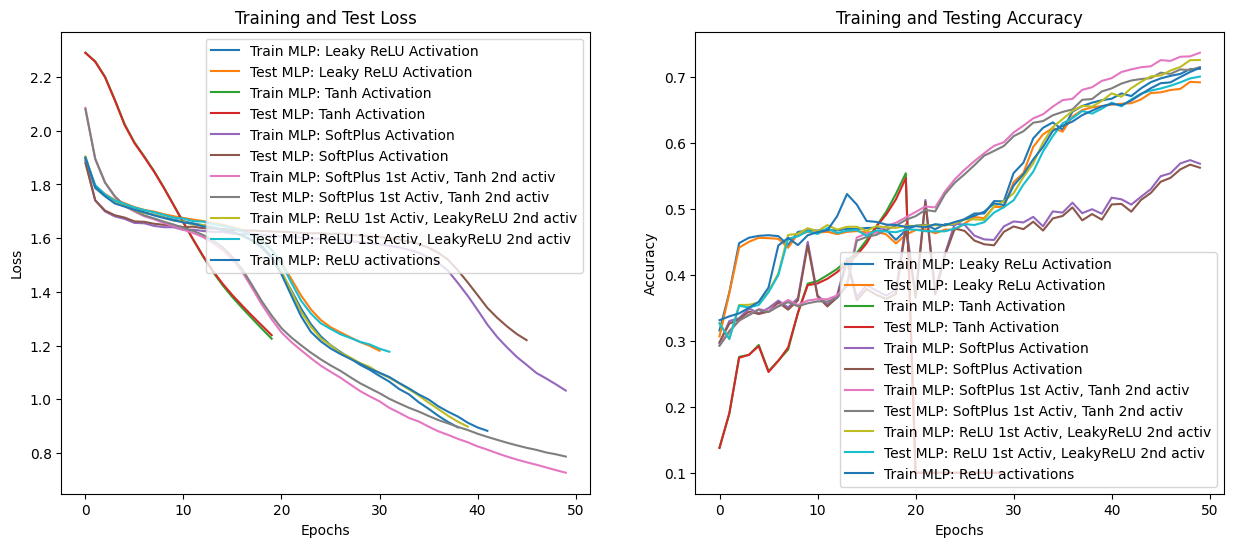

In [168]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(mlpLeaky.losses_train, label='Train MLP: Leaky ReLU Activation')
axes[0].plot(mlpLeaky.losses_valid, label='Test MLP: Leaky ReLU Activation')
axes[0].plot(mlptanh.losses_train, label='Train MLP: Tanh Activation')
axes[0].plot(mlptanh.losses_valid, label='Test MLP: Tanh Activation')
axes[0].plot(mlpsoftplus.losses_train, label='Train MLP: SoftPlus Activation')
axes[0].plot(mlpsoftplus.losses_valid, label='Test MLP: SoftPlus Activation')
axes[0].plot(mlpcomb1_losses_train, label='Train MLP: SoftPlus 1st Activ, Tanh 2nd activ')
axes[0].plot(mlpcomb1_losses_test, label='Test MLP: SoftPlus 1st Activ, Tanh 2nd activ')
axes[0].plot(mlpcomb2.losses_train, label='Train MLP: ReLU 1st Activ, LeakyReLU 2nd activ')
axes[0].plot(mlpcomb2.losses_valid, label='Test MLP: ReLU 1st Activ, LeakyReLU 2nd activ')
axes[0].plot(mlp2.losses_train, label='Train MLP: ReLU activations')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[1].plot(mlpLeaky.acc_train, label='Train MLP: Leaky ReLu Activation')
axes[1].plot(mlpLeaky.acc_valid, label='Test MLP: Leaky ReLu Activation')
axes[1].plot(mlptanh.acc_train, label='Train MLP: Tanh Activation')
axes[1].plot(mlptanh.acc_valid, label='Test MLP: Tanh Activation')
axes[1].plot(mlpsoftplus.acc_train, label='Train MLP: SoftPlus Activation')
axes[1].plot(mlpsoftplus.acc_valid, label='Test MLP: SoftPlus Activation')
axes[1].plot(mlpcomb1_acc_train, label='Train MLP: SoftPlus 1st Activ, Tanh 2nd activ')
axes[1].plot(mlpcomb1_acc_test, label='Test MLP: SoftPlus 1st Activ, Tanh 2nd activ')
axes[1].plot(mlpcomb2.acc_train, label='Train MLP: ReLU 1st Activ, LeakyReLU 2nd activ')
axes[1].plot(mlpcomb2.acc_valid, label='Test MLP: ReLU 1st Activ, LeakyReLU 2nd activ')
axes[1].plot(mlp2.acc_train, label='Train MLP: ReLU activations')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Testing Accuracy')
axes[1].legend()
plt.show()
fig.savefig("impact_activations.png")

#### Impact of Adding a Reg Term

In [201]:
l2=0.01
mlp_l2_001 = MLP(
    LinearLayer(n_features, n_hidden, l2), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden, n_hidden, l2), #Hidden layer 1
    ReLULayer(), # 
    LinearLayer(n_hidden, n_classes, l2), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [202]:
mlp_l2_001.fit( train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 30, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


epoch 1: Train loss: 1.904; Test Loss: 1.899, , Train Accuracy: 0.224, , Test Accuracy: 0.223


100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


epoch 2: Train loss: 1.791; Test Loss: 1.794, , Train Accuracy: 0.272, , Test Accuracy: 0.270


100%|██████████| 60/60 [00:38<00:00,  1.54it/s]


epoch 3: Train loss: 1.758; Test Loss: 1.763, , Train Accuracy: 0.352, , Test Accuracy: 0.350


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 4: Train loss: 1.739; Test Loss: 1.745, , Train Accuracy: 0.366, , Test Accuracy: 0.363


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 5: Train loss: 1.719; Test Loss: 1.726, , Train Accuracy: 0.365, , Test Accuracy: 0.361


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 6: Train loss: 1.709; Test Loss: 1.717, , Train Accuracy: 0.367, , Test Accuracy: 0.361


100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


epoch 7: Train loss: 1.695; Test Loss: 1.705, , Train Accuracy: 0.364, , Test Accuracy: 0.357


100%|██████████| 60/60 [00:34<00:00,  1.76it/s]


epoch 8: Train loss: 1.689; Test Loss: 1.699, , Train Accuracy: 0.370, , Test Accuracy: 0.367


100%|██████████| 60/60 [00:34<00:00,  1.74it/s]


epoch 9: Train loss: 1.682; Test Loss: 1.692, , Train Accuracy: 0.365, , Test Accuracy: 0.363


100%|██████████| 60/60 [00:33<00:00,  1.79it/s]


epoch 10: Train loss: 1.673; Test Loss: 1.684, , Train Accuracy: 0.372, , Test Accuracy: 0.368


100%|██████████| 60/60 [00:33<00:00,  1.81it/s]


epoch 11: Train loss: 1.667; Test Loss: 1.679, , Train Accuracy: 0.397, , Test Accuracy: 0.394


100%|██████████| 60/60 [00:34<00:00,  1.76it/s]


epoch 12: Train loss: 1.661; Test Loss: 1.673, , Train Accuracy: 0.421, , Test Accuracy: 0.421


100%|██████████| 60/60 [00:34<00:00,  1.75it/s]


epoch 13: Train loss: 1.654; Test Loss: 1.668, , Train Accuracy: 0.444, , Test Accuracy: 0.441


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


epoch 14: Train loss: 1.654; Test Loss: 1.666, , Train Accuracy: 0.460, , Test Accuracy: 0.456


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 15: Train loss: 1.644; Test Loss: 1.659, , Train Accuracy: 0.454, , Test Accuracy: 0.449


100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


epoch 16: Train loss: 1.641; Test Loss: 1.656, , Train Accuracy: 0.457, , Test Accuracy: 0.453


100%|██████████| 60/60 [00:34<00:00,  1.74it/s]


epoch 17: Train loss: 1.639; Test Loss: 1.653, , Train Accuracy: 0.464, , Test Accuracy: 0.459


100%|██████████| 60/60 [00:34<00:00,  1.75it/s]


epoch 18: Train loss: 1.636; Test Loss: 1.650, , Train Accuracy: 0.465, , Test Accuracy: 0.460


100%|██████████| 60/60 [00:33<00:00,  1.77it/s]


epoch 19: Train loss: 1.633; Test Loss: 1.647, , Train Accuracy: 0.472, , Test Accuracy: 0.466


100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


epoch 20: Train loss: 1.628; Test Loss: 1.644, , Train Accuracy: 0.468, , Test Accuracy: 0.461


100%|██████████| 60/60 [00:30<00:00,  1.94it/s]


epoch 21: Train loss: 1.626; Test Loss: 1.643, , Train Accuracy: 0.469, , Test Accuracy: 0.464


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


epoch 22: Train loss: 1.623; Test Loss: 1.640, , Train Accuracy: 0.471, , Test Accuracy: 0.464


100%|██████████| 60/60 [07:20<00:00,  7.35s/it]   


epoch 23: Train loss: 1.630; Test Loss: 1.647, , Train Accuracy: 0.453, , Test Accuracy: 0.448


100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


epoch 24: Train loss: 1.629; Test Loss: 1.646, , Train Accuracy: 0.469, , Test Accuracy: 0.463


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


epoch 25: Train loss: 1.676; Test Loss: 1.691, , Train Accuracy: 0.460, , Test Accuracy: 0.455


100%|██████████| 60/60 [00:42<00:00,  1.40it/s]


epoch 26: Train loss: 1.628; Test Loss: 1.641, , Train Accuracy: 0.460, , Test Accuracy: 0.456


100%|██████████| 60/60 [00:41<00:00,  1.44it/s]


epoch 27: Train loss: 1.616; Test Loss: 1.631, , Train Accuracy: 0.461, , Test Accuracy: 0.455


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 28: Train loss: 1.610; Test Loss: 1.627, , Train Accuracy: 0.465, , Test Accuracy: 0.461


100%|██████████| 60/60 [00:42<00:00,  1.42it/s]


epoch 29: Train loss: 1.635; Test Loss: 1.652, , Train Accuracy: 0.451, , Test Accuracy: 0.445


100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


epoch 30: Train loss: 1.586; Test Loss: 1.604, , Train Accuracy: 0.454, , Test Accuracy: 0.448
terminated after 30 epochs


In [203]:
l2=0.05
mlp_l2_005 = MLP(
    LinearLayer(n_features, n_hidden, l2), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden, n_hidden, l2), #Hidden layer 1
    ReLULayer(), # 
    LinearLayer(n_hidden, n_classes, l2), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [204]:
mlp_l2_005.fit( train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 30, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


epoch 1: Train loss: 1.919; Test Loss: 1.911, , Train Accuracy: 0.294, , Test Accuracy: 0.289


100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


epoch 2: Train loss: 1.797; Test Loss: 1.803, , Train Accuracy: 0.346, , Test Accuracy: 0.341


100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


epoch 3: Train loss: 1.758; Test Loss: 1.765, , Train Accuracy: 0.350, , Test Accuracy: 0.347


100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


epoch 4: Train loss: 1.741; Test Loss: 1.749, , Train Accuracy: 0.348, , Test Accuracy: 0.346


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


epoch 5: Train loss: 1.724; Test Loss: 1.734, , Train Accuracy: 0.348, , Test Accuracy: 0.345


100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


epoch 6: Train loss: 1.714; Test Loss: 1.724, , Train Accuracy: 0.354, , Test Accuracy: 0.350


100%|██████████| 60/60 [00:38<00:00,  1.54it/s]


epoch 7: Train loss: 1.701; Test Loss: 1.711, , Train Accuracy: 0.357, , Test Accuracy: 0.353


100%|██████████| 60/60 [00:37<00:00,  1.58it/s]


epoch 8: Train loss: 1.692; Test Loss: 1.703, , Train Accuracy: 0.360, , Test Accuracy: 0.355


100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


epoch 9: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:39<00:00,  1.54it/s]


epoch 10: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:38<00:00,  1.58it/s]


epoch 11: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


epoch 12: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


epoch 13: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:38<00:00,  1.57it/s]


epoch 14: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:40<00:00,  1.48it/s]


epoch 15: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:38<00:00,  1.56it/s]


epoch 16: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:42<00:00,  1.42it/s]


epoch 17: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:42<00:00,  1.40it/s]


epoch 18: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:42<00:00,  1.43it/s]


epoch 19: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


epoch 20: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


epoch 21: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:44<00:00,  1.34it/s]


epoch 22: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


epoch 23: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:42<00:00,  1.41it/s]


epoch 24: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


epoch 25: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


epoch 26: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


epoch 27: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


epoch 28: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


epoch 29: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


epoch 30: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100
terminated after 30 epochs


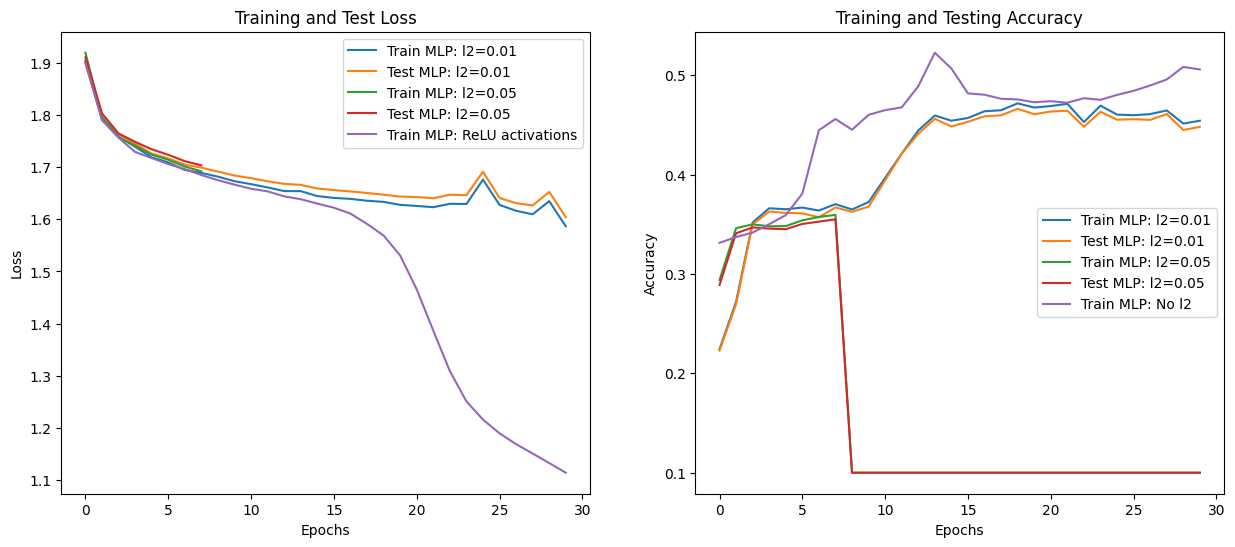

In [205]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(mlp_l2_001.losses_train, label='Train MLP: l2=0.01')
axes[0].plot(mlp_l2_001.losses_valid, label='Test MLP: l2=0.01')
axes[0].plot(mlp_l2_005.losses_train, label='Train MLP: l2=0.05')
axes[0].plot(mlp_l2_005.losses_valid, label='Test MLP: l2=0.05')
axes[0].plot(mlp2.losses_train[:30], label='Train MLP: ReLU activations')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[1].plot(mlp_l2_001.acc_train, label='Train MLP: l2=0.01')
axes[1].plot(mlp_l2_001.acc_valid, label='Test MLP: l2=0.01')
axes[1].plot(mlp_l2_005.acc_train, label='Train MLP: l2=0.05')
axes[1].plot(mlp_l2_005.acc_valid, label='Test MLP: l2=0.05')
axes[1].plot(mlp2.acc_train[:30], label='Train MLP: No l2')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Testing Accuracy')
axes[1].legend()
plt.show()
fig.savefig("impact_l2_2.png")

#### Impact of Not normalized data

In [175]:
mlp_not_norm = MLP(
    LinearLayer(n_features, n_hidden), #Input layer
    ReLULayer(), # 
    LinearLayer(n_hidden, n_hidden), #Hidden layer 1
    ReLULayer(), # 
    LinearLayer(n_hidden, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [176]:
mlp_not_norm.fit(train_images, train_labels, max_iters= 50, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [00:23<00:00,  2.51it/s]


epoch 1: Loss: 1.906, Accuracy: 0.303


100%|██████████| 60/60 [00:23<00:00,  2.52it/s]


epoch 2: Loss: 1.791, Accuracy: 0.350


100%|██████████| 60/60 [00:24<00:00,  2.41it/s]


epoch 3: Loss: 1.757, Accuracy: 0.344


100%|██████████| 60/60 [00:24<00:00,  2.43it/s]


epoch 4: Loss: 1.739, Accuracy: 0.361


100%|██████████| 60/60 [00:24<00:00,  2.45it/s]


epoch 5: Loss: 1.725, Accuracy: 0.361


100%|██████████| 60/60 [00:24<00:00,  2.43it/s]


epoch 6: Loss: 1.707, Accuracy: 0.353


100%|██████████| 60/60 [00:24<00:00,  2.45it/s]


epoch 7: Loss: 1.696, Accuracy: 0.394


100%|██████████| 60/60 [00:25<00:00,  2.39it/s]


epoch 8: Loss: 1.688, Accuracy: 0.438


100%|██████████| 60/60 [00:26<00:00,  2.27it/s]


epoch 9: Loss: 1.674, Accuracy: 0.460


100%|██████████| 60/60 [00:24<00:00,  2.41it/s]


epoch 10: Loss: 1.670, Accuracy: 0.463


100%|██████████| 60/60 [00:24<00:00,  2.42it/s]


epoch 11: Loss: 1.655, Accuracy: 0.469


100%|██████████| 60/60 [00:23<00:00,  2.52it/s]


epoch 12: Loss: 1.655, Accuracy: 0.472


100%|██████████| 60/60 [00:22<00:00,  2.61it/s]


epoch 13: Loss: 1.648, Accuracy: 0.473


100%|██████████| 60/60 [00:24<00:00,  2.42it/s]


epoch 14: Loss: 1.637, Accuracy: 0.470


100%|██████████| 60/60 [00:23<00:00,  2.57it/s]


epoch 15: Loss: 1.630, Accuracy: 0.471


100%|██████████| 60/60 [00:24<00:00,  2.49it/s]


epoch 16: Loss: 1.620, Accuracy: 0.472


100%|██████████| 60/60 [00:26<00:00,  2.30it/s]


epoch 17: Loss: 1.604, Accuracy: 0.468


100%|██████████| 60/60 [00:25<00:00,  2.34it/s]


epoch 18: Loss: 1.585, Accuracy: 0.456


100%|██████████| 60/60 [00:23<00:00,  2.60it/s]


epoch 19: Loss: 1.553, Accuracy: 0.472


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]


epoch 20: Loss: 1.504, Accuracy: 0.475


100%|██████████| 60/60 [00:23<00:00,  2.53it/s]


epoch 21: Loss: 1.444, Accuracy: 0.476


100%|██████████| 60/60 [00:22<00:00,  2.67it/s]


epoch 22: Loss: 1.365, Accuracy: 0.464


100%|██████████| 60/60 [00:22<00:00,  2.71it/s]


epoch 23: Loss: 1.297, Accuracy: 0.475


100%|██████████| 60/60 [00:22<00:00,  2.65it/s]


epoch 24: Loss: 1.247, Accuracy: 0.481


100%|██████████| 60/60 [00:22<00:00,  2.63it/s]


epoch 25: Loss: 1.213, Accuracy: 0.481


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


epoch 26: Loss: 1.187, Accuracy: 0.489


100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


epoch 27: Loss: 1.165, Accuracy: 0.485


100%|██████████| 60/60 [00:24<00:00,  2.43it/s]


epoch 28: Loss: 1.146, Accuracy: 0.497


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


epoch 29: Loss: 1.128, Accuracy: 0.514


100%|██████████| 60/60 [00:20<00:00,  2.94it/s]


epoch 30: Loss: 1.106, Accuracy: 0.516


100%|██████████| 60/60 [00:21<00:00,  2.79it/s]


epoch 31: Loss: 1.092, Accuracy: 0.546


100%|██████████| 60/60 [00:21<00:00,  2.74it/s]


epoch 32: Loss: 1.071, Accuracy: 0.567


100%|██████████| 60/60 [00:23<00:00,  2.50it/s]


epoch 33: Loss: 1.049, Accuracy: 0.581


100%|██████████| 60/60 [00:22<00:00,  2.71it/s]


epoch 34: Loss: 1.032, Accuracy: 0.613


100%|██████████| 60/60 [00:22<00:00,  2.69it/s]


epoch 35: Loss: 1.006, Accuracy: 0.627


100%|██████████| 60/60 [00:22<00:00,  2.62it/s]


epoch 36: Loss: 0.982, Accuracy: 0.633


100%|██████████| 60/60 [00:23<00:00,  2.57it/s]


epoch 37: Loss: 0.960, Accuracy: 0.646


100%|██████████| 60/60 [00:24<00:00,  2.41it/s]


epoch 38: Loss: 0.940, Accuracy: 0.644


100%|██████████| 60/60 [00:22<00:00,  2.66it/s]


epoch 39: Loss: 0.922, Accuracy: 0.652


100%|██████████| 60/60 [00:21<00:00,  2.77it/s]


epoch 40: Loss: 0.900, Accuracy: 0.660


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


epoch 41: Loss: 0.887, Accuracy: 0.666


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


epoch 42: Loss: nan, Accuracy: 0.668


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


epoch 43: Loss: nan, Accuracy: 0.670


100%|██████████| 60/60 [00:21<00:00,  2.76it/s]


epoch 44: Loss: nan, Accuracy: 0.678


100%|██████████| 60/60 [00:22<00:00,  2.65it/s]


epoch 45: Loss: nan, Accuracy: 0.686


100%|██████████| 60/60 [00:23<00:00,  2.60it/s]


epoch 46: Loss: nan, Accuracy: 0.695


100%|██████████| 60/60 [00:21<00:00,  2.75it/s]


epoch 47: Loss: nan, Accuracy: 0.698


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


epoch 48: Loss: nan, Accuracy: 0.697


100%|██████████| 60/60 [00:22<00:00,  2.71it/s]


epoch 49: Loss: nan, Accuracy: 0.709


100%|██████████| 60/60 [00:28<00:00,  2.10it/s]


epoch 50: Loss: nan, Accuracy: 0.713
terminated after 50 epochs


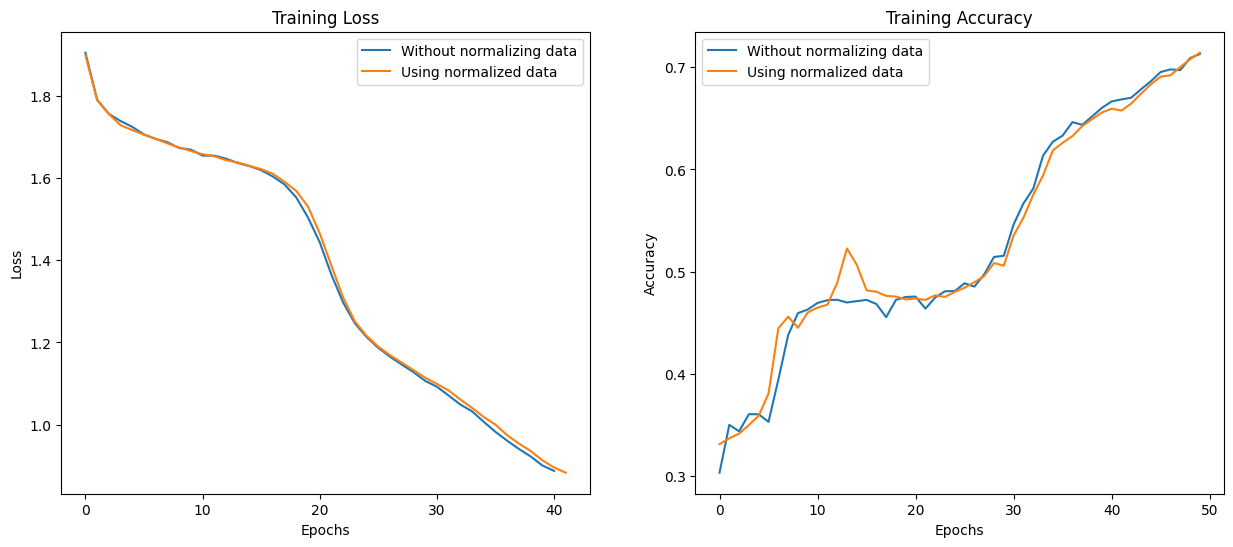

In [178]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(mlp_not_norm.losses_train, label='Without normalizing data')
axes[0].plot(mlp2.losses_train, label='Using normalized data')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[1].plot(mlp_not_norm.acc_train, label='Without normalizing data')
axes[1].plot(mlp2.acc_train, label='Using normalized data')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].legend()
plt.show()
fig.savefig("impact_data.png")

In [179]:
#Test accuracy for the 3 models
test_res=mlp_not_norm.predict(test_images)
print("Test accuracy for model trained unsing not-normalized data: ", evaluate_acc(test_res, test_labels))
test_res=mlp2.predict(test_images_norm)
print("Test accuracy for model trained unsing normalized data: ", evaluate_acc(test_res, test_labels))


Test accuracy for model trained unsing not-normalized data:  0.6911
Test accuracy for model trained unsing normalized data:  0.6954


### Convoluntional Nerual Network (ConvNet)

In [14]:
# we use keras datasets again 
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

In [15]:
# double check the training and testing size
print('Training data shape is : ', train_X.shape, train_Y.shape)
print('Testing data shape is: ', test_X.shape, test_Y.shape)

Training data shape is :  (60000, 28, 28) (60000,)
Testing data shape is:  (10000, 28, 28) (10000,)


In [16]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [17]:
#Data Preprocessing for CNN
#convert each 28 x 28 image of the train and test set into 
#a matrix of size 28 x 28 x 1 which is fed into the network.
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [18]:
#convert data type to float32, and rescale the pixel values in range 0 - 1
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In [19]:
# convert the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [20]:
# split the training set into training (80%) and validation set(20%)
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=36)

In [21]:
# now we build the CNN 
# The structure is: input- conv (64-3*3) - maxpooling- conv (128- 3*3)- maxpooling- faltten-
# FC1 (128 hidden)- FC2 (128 hidden)- output(10)

import keras
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [22]:
# we use epochs=20
batch_size = 64
epochs = 20
num_classes = 10

In [23]:
fashion_model = Sequential()

# conv 1: 64 hidden size with 3*3 filter
fashion_model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))

# conv 2: 128 hidden size with 3*3 filter
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

# flatten
fashion_model.add(Flatten())

# FC1: 128 hidden size
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1)) 

# FC2: 128 hidden size
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1)) 

fashion_model.add(Dense(num_classes, activation='softmax'))

In [24]:
# compile the model, here learning_rate=0.001 by default
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [25]:
# summary
fashion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                    

In [26]:
# fit the model: 
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 52s 68ms/step - loss: 0.4262 - accuracy: 0.8451 - val_loss: 0.2922 - val_accuracy: 0.8907
Epoch 2/20
750/750 [==============================] - 47s 62ms/step - loss: 0.2677 - accuracy: 0.9016 - val_loss: 0.2520 - val_accuracy: 0.9050
Epoch 3/20
750/750 [==============================] - 47s 63ms/step - loss: 0.2209 - accuracy: 0.9172 - val_loss: 0.2252 - val_accuracy: 0.9179
Epoch 4/20
750/750 [==============================] - 47s 63ms/step - loss: 0.1873 - accuracy: 0.9293 - val_loss: 0.2216 - val_accuracy: 0.9209
Epoch 5/20
750/750 [==============================] - 47s 63ms/step - loss: 0.1583 - accuracy: 0.9402 - val_loss: 0.2364 - val_accuracy: 0.9149
Epoch 6/20
750/750 [==============================] - 47s 62ms/step - loss: 0.1324 - accuracy: 0.9495 - val_loss: 0.2333 - val_accuracy: 0.9194
Epoch 7/20
750/750 [==============================] - 47s 62ms/step - loss: 0.1131 - accuracy: 0.9565 - val_loss: 0.2492 - val_accuracy:

In [27]:
# evaluate the model in the test set 
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5529868006706238
Test accuracy: 0.9154999852180481


In [ ]:
# the validation accuracy is about 92%. 
# the test accuracy is 91.5%

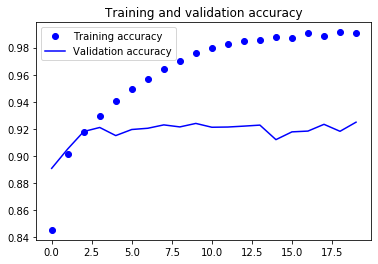

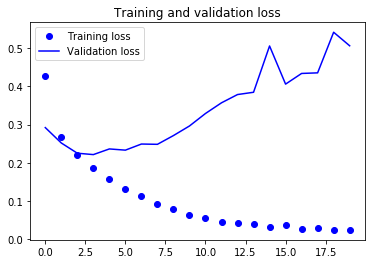

In [28]:
# However, the model seems overfitting by the following plots: 
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
batch_size = 64
epochs = 20
num_classes = 10

In [30]:
fashion_model = Sequential()

fashion_model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25)) # here we add the dropout layer

fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.5))# here we add the dropout layer

fashion_model.add(Flatten())

fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1)) 
fashion_model.add(Dropout(0.5))# here we add the dropout layer

fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1)) 
fashion_model.add(Dropout(0.5))# here we add the dropout layer

fashion_model.add(Dense(num_classes, activation='softmax'))

In [31]:
fashion_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

In [32]:
# compile the model, learning_rate=0.001 by default
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [33]:
# train the model again
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 58s 77ms/step - loss: 0.6732 - accuracy: 0.7563 - val_loss: 0.3483 - val_accuracy: 0.8684
Epoch 2/20
750/750 [==============================] - 58s 77ms/step - loss: 0.4134 - accuracy: 0.8533 - val_loss: 0.2902 - val_accuracy: 0.8907
Epoch 3/20
750/750 [==============================] - 57s 76ms/step - loss: 0.3603 - accuracy: 0.8718 - val_loss: 0.2712 - val_accuracy: 0.8970
Epoch 4/20
750/750 [==============================] - 58s 77ms/step - loss: 0.3297 - accuracy: 0.8832 - val_loss: 0.2447 - val_accuracy: 0.9078
Epoch 5/20
750/750 [==============================] - 58s 78ms/step - loss: 0.3131 - accuracy: 0.8863 - val_loss: 0.2407 - val_accuracy: 0.9107
Epoch 6/20
750/750 [==============================] - 58s 78ms/step - loss: 0.2969 - accuracy: 0.8937 - val_loss: 0.2402 - val_accuracy: 0.9114
Epoch 7/20
750/750 [==============================] - 59s 79ms/step - loss: 0.2821 - accuracy: 0.8973 - val_loss: 0.2319 - val_accuracy:

In [34]:
# Redo the model evaluation on the Test Set 
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)

313/313 [==============================] - 4s 12ms/step - loss: 0.2318 - accuracy: 0.9181


In [35]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.23181083798408508
Test accuracy: 0.9180999994277954


In [ ]:
# the validation accuracy is about 93%. 
# the test accuracy is 91.8%
# this time we can see the test loss decrease a lot by adding the dropout layers.

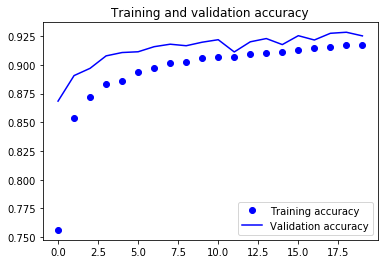

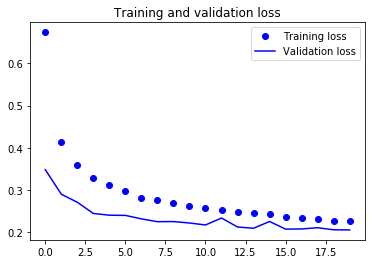

In [44]:
# we plot the accuracy and loss again: 
accuracy = fashion_train_dropout.history['accuracy']
val_accuracy = fashion_train_dropout.history['val_accuracy']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [37]:
# it looks better now

In [187]:
# Based on the results above, we will try to build our own architectures, 
# main take home messages:
# 1. Going deeper increases accuracy
# 2. Going wider increases accuracy
# 3. using softplus + tanh stabilizes loss + accuracy over epochs
# 4. Using normalized data stabilizes predictions.
# Our first proposed model will be a 2-layer MLP with 256 Hidden units + first activation is softplus and second is Tanh
n_hidden
mlp_final_1 = MLP(
    LinearLayer(n_features, n_hidden_2), #Input layer
    Softpluslayer(), # 
    LinearLayer(n_hidden_2, n_hidden_2), #Hidden layer 1
    tanhLayer(), # 
    LinearLayer(n_hidden_2, n_classes), #Hidden layer 2
    SoftmaxOutputLayer()
)

In [188]:
mlp_final_1.fit(train_images_norm, train_labels, test_images_norm, test_labels, max_iters= 100, batch_size=1000, lr=0.01)

100%|██████████| 60/60 [01:23<00:00,  1.39s/it]


epoch 1: Train loss: 2.000; Test Loss: 1.992, , Train Accuracy: 0.341, , Test Accuracy: 0.339


100%|██████████| 60/60 [01:30<00:00,  1.51s/it]


epoch 2: Train loss: 1.796; Test Loss: 1.796, , Train Accuracy: 0.387, , Test Accuracy: 0.387


100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


epoch 3: Train loss: 1.731; Test Loss: 1.733, , Train Accuracy: 0.349, , Test Accuracy: 0.347


100%|██████████| 60/60 [01:32<00:00,  1.53s/it]


epoch 4: Train loss: 1.703; Test Loss: 1.705, , Train Accuracy: 0.351, , Test Accuracy: 0.351


100%|██████████| 60/60 [01:31<00:00,  1.53s/it]


epoch 5: Train loss: 1.681; Test Loss: 1.684, , Train Accuracy: 0.371, , Test Accuracy: 0.370


100%|██████████| 60/60 [01:38<00:00,  1.65s/it]


epoch 6: Train loss: 1.663; Test Loss: 1.668, , Train Accuracy: 0.427, , Test Accuracy: 0.426


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


epoch 7: Train loss: 1.654; Test Loss: 1.659, , Train Accuracy: 0.419, , Test Accuracy: 0.418


100%|██████████| 60/60 [01:25<00:00,  1.42s/it]


epoch 8: Train loss: 1.638; Test Loss: 1.643, , Train Accuracy: 0.449, , Test Accuracy: 0.443


100%|██████████| 60/60 [01:26<00:00,  1.45s/it]


epoch 9: Train loss: 1.624; Test Loss: 1.630, , Train Accuracy: 0.463, , Test Accuracy: 0.459


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


epoch 10: Train loss: 1.609; Test Loss: 1.617, , Train Accuracy: 0.463, , Test Accuracy: 0.458


100%|██████████| 60/60 [01:27<00:00,  1.46s/it]


epoch 11: Train loss: 1.591; Test Loss: 1.598, , Train Accuracy: 0.467, , Test Accuracy: 0.463


100%|██████████| 60/60 [01:30<00:00,  1.51s/it]


epoch 12: Train loss: 1.567; Test Loss: 1.576, , Train Accuracy: 0.464, , Test Accuracy: 0.460


100%|██████████| 60/60 [01:26<00:00,  1.45s/it]


epoch 13: Train loss: 1.532; Test Loss: 1.540, , Train Accuracy: 0.464, , Test Accuracy: 0.459


100%|██████████| 60/60 [01:29<00:00,  1.49s/it]


epoch 14: Train loss: 1.481; Test Loss: 1.490, , Train Accuracy: 0.461, , Test Accuracy: 0.457


100%|██████████| 60/60 [03:48<00:00,  3.81s/it]


epoch 15: Train loss: 1.415; Test Loss: 1.425, , Train Accuracy: 0.480, , Test Accuracy: 0.476


100%|██████████| 60/60 [01:27<00:00,  1.45s/it]


epoch 16: Train loss: 1.341; Test Loss: 1.354, , Train Accuracy: 0.493, , Test Accuracy: 0.486


100%|██████████| 60/60 [01:34<00:00,  1.57s/it]


epoch 17: Train loss: 1.278; Test Loss: 1.294, , Train Accuracy: 0.496, , Test Accuracy: 0.488


100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


epoch 18: Train loss: 1.228; Test Loss: 1.245, , Train Accuracy: 0.513, , Test Accuracy: 0.505


100%|██████████| 60/60 [01:32<00:00,  1.54s/it]


epoch 19: Train loss: 1.185; Test Loss: 1.204, , Train Accuracy: 0.529, , Test Accuracy: 0.523


100%|██████████| 60/60 [01:31<00:00,  1.53s/it]


epoch 20: Train loss: 1.151; Test Loss: 1.173, , Train Accuracy: 0.536, , Test Accuracy: 0.531


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


epoch 21: Train loss: 1.121; Test Loss: 1.144, , Train Accuracy: 0.562, , Test Accuracy: 0.557


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


epoch 22: Train loss: 1.092; Test Loss: 1.117, , Train Accuracy: 0.581, , Test Accuracy: 0.577


100%|██████████| 60/60 [01:23<00:00,  1.39s/it]


epoch 23: Train loss: 1.068; Test Loss: 1.096, , Train Accuracy: 0.587, , Test Accuracy: 0.580


100%|██████████| 60/60 [01:23<00:00,  1.40s/it]


epoch 24: Train loss: 1.048; Test Loss: 1.076, , Train Accuracy: 0.607, , Test Accuracy: 0.601


100%|██████████| 60/60 [01:22<00:00,  1.37s/it]


epoch 25: Train loss: 1.023; Test Loss: 1.053, , Train Accuracy: 0.614, , Test Accuracy: 0.609


100%|██████████| 60/60 [01:24<00:00,  1.40s/it]


epoch 26: Train loss: 1.002; Test Loss: 1.033, , Train Accuracy: 0.626, , Test Accuracy: 0.620


100%|██████████| 60/60 [01:26<00:00,  1.44s/it]


epoch 27: Train loss: 0.980; Test Loss: 1.015, , Train Accuracy: 0.635, , Test Accuracy: 0.630


100%|██████████| 60/60 [01:31<00:00,  1.52s/it]


epoch 28: Train loss: 0.960; Test Loss: 0.996, , Train Accuracy: 0.645, , Test Accuracy: 0.636


100%|██████████| 60/60 [01:29<00:00,  1.49s/it]


epoch 29: Train loss: 0.943; Test Loss: 0.980, , Train Accuracy: 0.653, , Test Accuracy: 0.642


100%|██████████| 60/60 [01:34<00:00,  1.58s/it]


epoch 30: Train loss: 0.927; Test Loss: 0.965, , Train Accuracy: 0.662, , Test Accuracy: 0.650


100%|██████████| 60/60 [01:26<00:00,  1.43s/it]


epoch 31: Train loss: 0.909; Test Loss: 0.949, , Train Accuracy: 0.671, , Test Accuracy: 0.658


100%|██████████| 60/60 [01:30<00:00,  1.50s/it]


epoch 32: Train loss: 0.891; Test Loss: 0.933, , Train Accuracy: 0.677, , Test Accuracy: 0.664


100%|██████████| 60/60 [01:24<00:00,  1.40s/it]


epoch 33: Train loss: 0.874; Test Loss: 0.918, , Train Accuracy: 0.689, , Test Accuracy: 0.673


100%|██████████| 60/60 [01:26<00:00,  1.44s/it]


epoch 34: Train loss: 0.858; Test Loss: 0.904, , Train Accuracy: 0.689, , Test Accuracy: 0.675


100%|██████████| 60/60 [01:27<00:00,  1.46s/it]


epoch 35: Train loss: 0.844; Test Loss: 0.891, , Train Accuracy: 0.701, , Test Accuracy: 0.688


100%|██████████| 60/60 [01:26<00:00,  1.45s/it]


epoch 36: Train loss: 0.827; Test Loss: 0.876, , Train Accuracy: 0.707, , Test Accuracy: 0.692


100%|██████████| 60/60 [01:30<00:00,  1.50s/it]


epoch 37: Train loss: 0.813; Test Loss: 0.864, , Train Accuracy: 0.709, , Test Accuracy: 0.695


100%|██████████| 60/60 [01:32<00:00,  1.54s/it]


epoch 38: Train loss: 0.799; Test Loss: 0.851, , Train Accuracy: 0.717, , Test Accuracy: 0.702


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


epoch 39: Train loss: 0.787; Test Loss: 0.840, , Train Accuracy: 0.723, , Test Accuracy: 0.706


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


epoch 40: Train loss: 0.773; Test Loss: 0.828, , Train Accuracy: 0.727, , Test Accuracy: 0.710


100%|██████████| 60/60 [01:24<00:00,  1.40s/it]


epoch 41: Train loss: 0.760; Test Loss: 0.817, , Train Accuracy: 0.725, , Test Accuracy: 0.709


100%|██████████| 60/60 [01:25<00:00,  1.43s/it]


epoch 42: Train loss: 0.752; Test Loss: 0.809, , Train Accuracy: 0.735, , Test Accuracy: 0.717


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


epoch 43: Train loss: 0.740; Test Loss: 0.799, , Train Accuracy: 0.738, , Test Accuracy: 0.719


100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


epoch 44: Train loss: 0.730; Test Loss: 0.790, , Train Accuracy: 0.738, , Test Accuracy: 0.721


100%|██████████| 60/60 [01:27<00:00,  1.45s/it]


epoch 45: Train loss: 0.721; Test Loss: 0.782, , Train Accuracy: 0.747, , Test Accuracy: 0.725


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


epoch 46: Train loss: 0.712; Test Loss: 0.775, , Train Accuracy: 0.750, , Test Accuracy: 0.726


100%|██████████| 60/60 [01:15<00:00,  1.26s/it]


epoch 47: Train loss: 0.705; Test Loss: 0.769, , Train Accuracy: 0.754, , Test Accuracy: 0.732


100%|██████████| 60/60 [01:22<00:00,  1.37s/it]


epoch 48: Train loss: 0.696; Test Loss: 0.762, , Train Accuracy: 0.748, , Test Accuracy: 0.727


100%|██████████| 60/60 [01:14<00:00,  1.24s/it]


epoch 49: Train loss: 0.688; Test Loss: 0.755, , Train Accuracy: 0.759, , Test Accuracy: 0.737


100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


epoch 50: Train loss: 0.682; Test Loss: 0.750, , Train Accuracy: 0.759, , Test Accuracy: 0.736


100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


epoch 51: Train loss: 0.672; Test Loss: 0.742, , Train Accuracy: 0.757, , Test Accuracy: 0.732


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


epoch 52: Train loss: 0.663; Test Loss: 0.735, , Train Accuracy: 0.765, , Test Accuracy: 0.740


100%|██████████| 60/60 [01:34<00:00,  1.57s/it]


epoch 53: Train loss: 0.661; Test Loss: 0.733, , Train Accuracy: 0.769, , Test Accuracy: 0.741


100%|██████████| 60/60 [01:31<00:00,  1.52s/it]


epoch 54: Train loss: 0.654; Test Loss: 0.726, , Train Accuracy: 0.772, , Test Accuracy: 0.744


100%|██████████| 60/60 [01:33<00:00,  1.55s/it]


epoch 55: Train loss: 0.646; Test Loss: 0.722, , Train Accuracy: 0.775, , Test Accuracy: 0.746


100%|██████████| 60/60 [01:32<00:00,  1.55s/it]


epoch 56: Train loss: 0.641; Test Loss: 0.718, , Train Accuracy: 0.776, , Test Accuracy: 0.749


100%|██████████| 60/60 [01:39<00:00,  1.65s/it]


epoch 57: Train loss: 0.635; Test Loss: 0.712, , Train Accuracy: 0.772, , Test Accuracy: 0.747


100%|██████████| 60/60 [01:35<00:00,  1.60s/it]


epoch 58: Train loss: 0.633; Test Loss: 0.711, , Train Accuracy: 0.778, , Test Accuracy: 0.748


100%|██████████| 60/60 [01:39<00:00,  1.65s/it]


epoch 59: Train loss: 0.624; Test Loss: 0.704, , Train Accuracy: 0.779, , Test Accuracy: 0.750


100%|██████████| 60/60 [01:33<00:00,  1.56s/it]


epoch 60: Train loss: 0.620; Test Loss: 0.700, , Train Accuracy: 0.779, , Test Accuracy: 0.750


100%|██████████| 60/60 [01:26<00:00,  1.44s/it]


epoch 61: Train loss: 0.615; Test Loss: 0.696, , Train Accuracy: 0.785, , Test Accuracy: 0.753


100%|██████████| 60/60 [01:27<00:00,  1.47s/it]


epoch 62: Train loss: 0.611; Test Loss: 0.693, , Train Accuracy: 0.787, , Test Accuracy: 0.756


100%|██████████| 60/60 [01:23<00:00,  1.40s/it]


epoch 63: Train loss: 0.603; Test Loss: 0.687, , Train Accuracy: 0.788, , Test Accuracy: 0.757


100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


epoch 64: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:18<00:00,  1.32s/it]


epoch 65: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:22<00:00,  1.37s/it]


epoch 66: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:20<00:00,  1.35s/it]


epoch 67: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:29<00:00,  1.48s/it]


epoch 68: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:28<00:00,  1.48s/it]


epoch 69: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


epoch 70: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


epoch 71: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


epoch 72: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:26<00:00,  1.45s/it]


epoch 73: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:33<00:00,  1.55s/it]


epoch 74: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:40<00:00,  1.67s/it]


epoch 75: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


epoch 76: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


epoch 77: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:22<00:00,  1.37s/it]


epoch 78: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:19<00:00,  1.32s/it]


epoch 79: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


epoch 80: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


epoch 81: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


epoch 82: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


epoch 83: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


epoch 84: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


epoch 85: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


epoch 86: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


epoch 87: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:32<00:00,  1.55s/it]


epoch 88: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:23<00:00,  1.39s/it]


epoch 89: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:22<00:00,  1.37s/it]


epoch 90: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:22<00:00,  1.37s/it]


epoch 91: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


epoch 92: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:17<00:00,  1.28s/it]


epoch 93: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


epoch 94: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:23<00:00,  1.39s/it]


epoch 95: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


epoch 96: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:26<00:00,  1.44s/it]


epoch 97: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:21<00:00,  1.37s/it]


epoch 98: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:51<00:00,  1.86s/it]


epoch 99: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


epoch 100: Train loss: nan; Test Loss: nan, , Train Accuracy: 0.100, , Test Accuracy: 0.100
terminated after 100 epochs


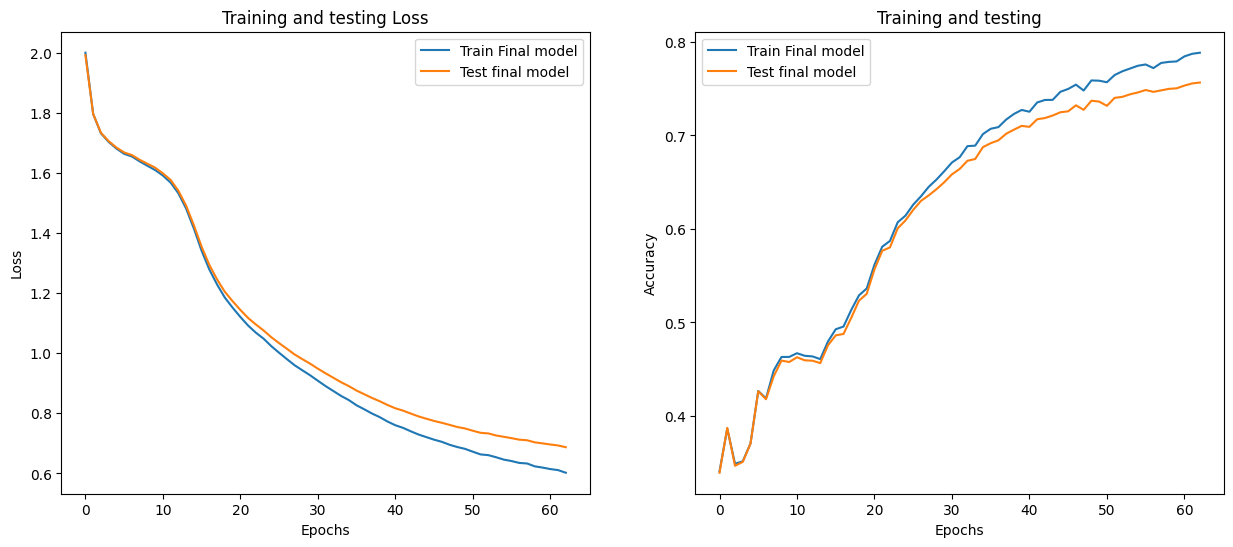

In [192]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(mlp_final_1.losses_train[:65], label='Train Final model')
axes[0].plot(mlp_final_1.losses_valid[:65], label='Test final model')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and testing Loss')
axes[0].legend()
axes[1].plot(mlp_final_1.acc_train[:63], label='Train Final model')
axes[1].plot(mlp_final_1.acc_valid[:63], label='Test final model')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and testing')
axes[1].legend()
plt.show()
fig.savefig("final.png")

In [219]:
#FIN